In [15]:
import requests
from bs4 import BeautifulSoup
from astropy.io import fits
import matplotlib.pyplot as plt
from desispec.io.spectra import read_spectra
import numpy as np
from desitarget.targetmask import desi_mask
import pandas as pd

In [4]:
r_i = requests.get("https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/dark/") 
soup_i = BeautifulSoup(r_i.content, "html.parser")
all_links_i = soup_i.find_all("a")
linkList_i = [link['href'] for link in all_links_i[1:]] # creates a list of all the first indicies of the coaad files

all_lists = []
for i in range(len(linkList_i)):
    r_j = requests.get("https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/dark/" + str(linkList_i[i]))
    soup_j = BeautifulSoup(r_j.content, "html.parser")
    all_links_j = soup_j.find_all("a")
    linkList_j = [link['href'] for link in all_links_j] 
    all_lists.append(linkList_j[1:]) # creates a list of all the second indicies of the coaad files for each of the first indicies

In [5]:
hdul = fits.open("qso_cat_dr1_main_dark_healpix_zlya-v0.fits") # lya quasar catalog
data = hdul[1].data
flux_b = []; flux_r = []; flux_z = [] # Initialize lists
wave_b = []; wave_r = []; wave_z = []
ivar_b = []; ivar_r = []; ivar_z = []
zArray = []; validQSOidx = []
for i in range(1): #range(len(linkList_i))
    for j in range(2): #range(len(all_lists[i]))
        r = requests.get("https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/dark/" +  str(linkList_i[i]) # uses url generated from linkList and all_lists
                     + str(all_lists[i][j]) + "coadd-main-dark-"+  str(all_lists[i][j]).replace("/","") + ".fits")
        print(r.status_code)
        with open("coadd-main-dark-" + str(all_lists[i][j]).replace("/","") + ".fits", "wb") as fp: #dowloads the file with the name generated from all_lists
            fp.write(r.content)
            
        spec = read_spectra("coadd-main-dark-" + str(all_lists[i][j]).replace("/","") + ".fits" ) # gets spectra data from the coaad file
        fibermap = spec.fibermap
        coadd_dict = {tid: ii for ii, tid in enumerate(fibermap["TARGETID"])} # creates a dictionary of indicies with the target id as the key

        for ii, tid in enumerate(data["TARGETID"]):
            if (data["Z"][ii] > 2) and (data["ZWARN"][ii] == 0) and (data["BI_CIV"][ii] == 0): #checks that Z > Z_min, ZWARN = 0, and BI_CIV > BI_CIV_min
                if tid in coadd_dict: # checks that the target id from the lya QSO catelog is in the coadd file
                    idx = coadd_dict[tid]
                    validQSOidx.append(coadd_dict[tid]) # generates a list of indicies of valid QSOs
                    zArray.append(data["Z"][ii]) # generates a list of redshift of all the valid QSOs
                    wave_b.append(spec.wave['b']/(1+data["Z"][ii])) # appends an array of the range of wavelgenths in the rest frame for each arm
                    wave_r.append(spec.wave['r']/(1+data["Z"][ii]))
                    wave_z.append(spec.wave['z']/(1+data["Z"][ii]))
                    flux_b.append(spec.flux['b'][idx])
                    flux_r.append(spec.flux['r'][idx])
                    flux_z.append(spec.flux['z'][idx]) # appends an array of the flux and ivar for each arm for all the valid QSOs
                    ivar_b.append(spec.ivar['b'][idx])
                    ivar_r.append(spec.ivar['r'][idx])
                    ivar_z.append(spec.ivar['z'][idx])
    
        filename = "coadd-main-dark-" + str(all_lists[i][j]).replace("/", "") + ".fits"
        !rm -rf "{filename}" # removes the downloaded coadd file




200
INFO:spectra.py:451:read_spectra: iotime 0.530 sec to read spectra from:  coadd-main-dark-0.fits at 2025-06-24T13:01:37.188539
200
INFO:spectra.py:451:read_spectra: iotime 0.477 sec to read spectra from:  coadd-main-dark-1.fits at 2025-06-24T13:02:52.478038


In [ ]:
print(flux_b[0].shape, flux_r[0].shape, flux_z[0].shape) #Check the length of each arm matches across all data
print(ivar_b[0].shape, ivar_r[0].shape, ivar_z[0].shape)
print(wave_b[0].shape, wave_r[0].shape, wave_z[0].shape)

print(len(flux_b), len(flux_r), len(flux_z))  # Check that the dimensions match
print(len(ivar_b), len(ivar_r), len(ivar_z))
print(len(wave_b), len(wave_r), len(wave_z))

flux = []; ivar = []; wave = [] # Initialize lists to combine flux, ivar, and wavelength from all arms
for ii in range(len(flux_b)):
    # Concatenate arrays from all arms
    flux_concat = np.concatenate([flux_b[ii], flux_r[ii], flux_z[ii]])
    ivar_concat = np.concatenate([ivar_b[ii], ivar_r[ii], ivar_z[ii]])
    wave_concat = np.concatenate([wave_b[ii], wave_r[ii], wave_z[ii]])
    # Sort by wavelength
    sort_idx = np.argsort(wave_concat)
    flux.append(flux_concat[sort_idx])
    ivar.append(ivar_concat[sort_idx])
    wave.append(wave_concat[sort_idx])

112 112 112
112 112 112
112 112 112


In [30]:
for ii in range(4): #(len(validQSOidx)):
    QSOnum = data["TARGETID"][validQSOidx[ii]]
    rows = []
    for j in range(len(wave[ii])): # Create rows object with all the data
        rows.append([wave[ii][j], flux[ii][j], ivar[ii][j]])
    df = pd.DataFrame(rows,columns=['wavelength', 'flux', 'ivar'])  # Convert to DataFrame
    filename = f'{QSOnum}.csv'
    with open(filename, 'w') as f: # Save to CSV file
        f.write(f'QSOID: {QSOnum}\nz: {zArray[ii]}\n')
        df.to_csv(f, index=False)

/var/folders/k_/ckx4f9nx64n4drrpl2p89_0m0000gn/T/ipykernel_22379/989394338.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


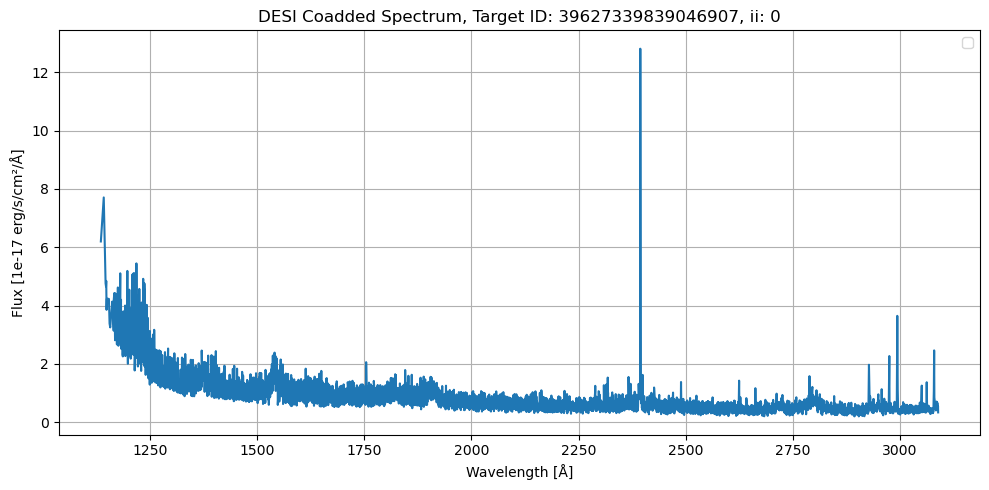

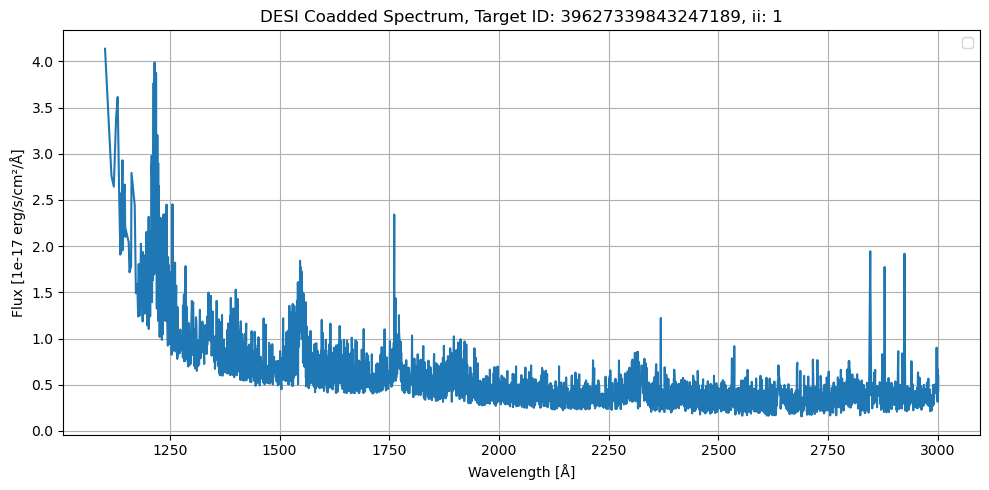

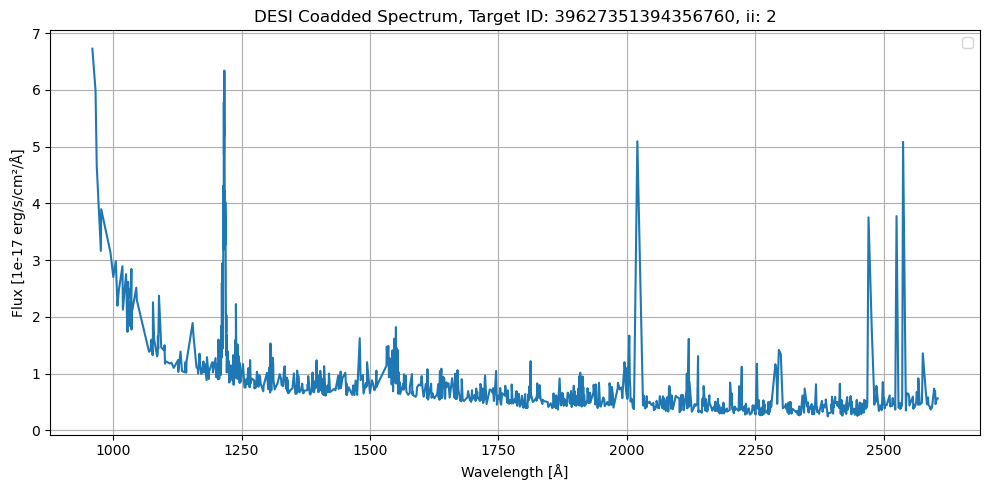

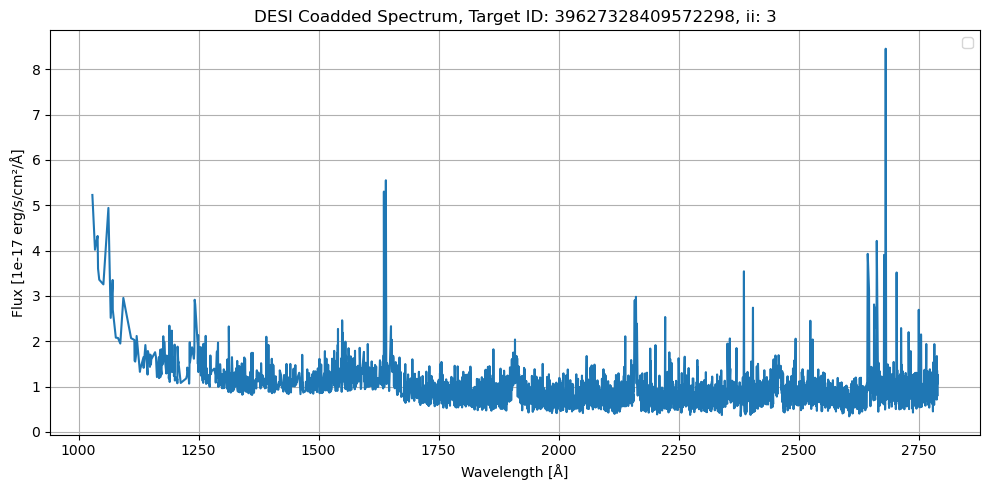

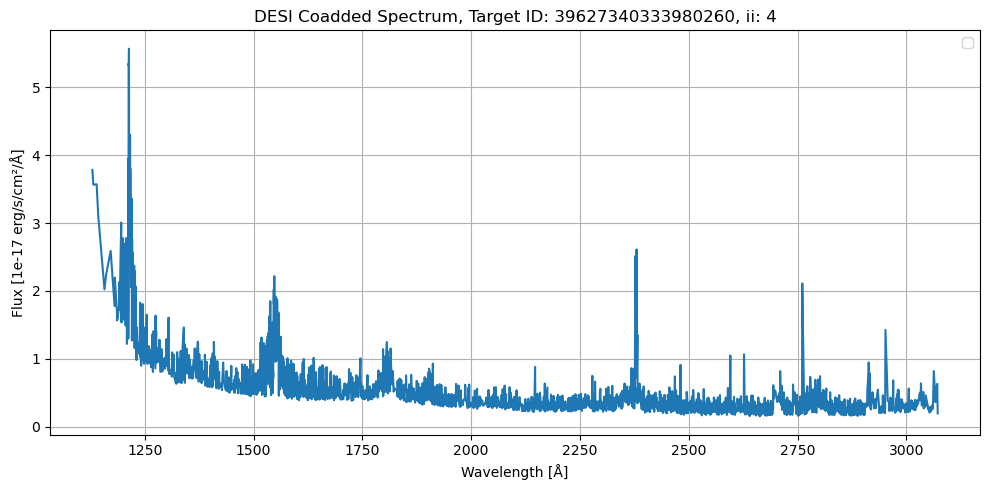

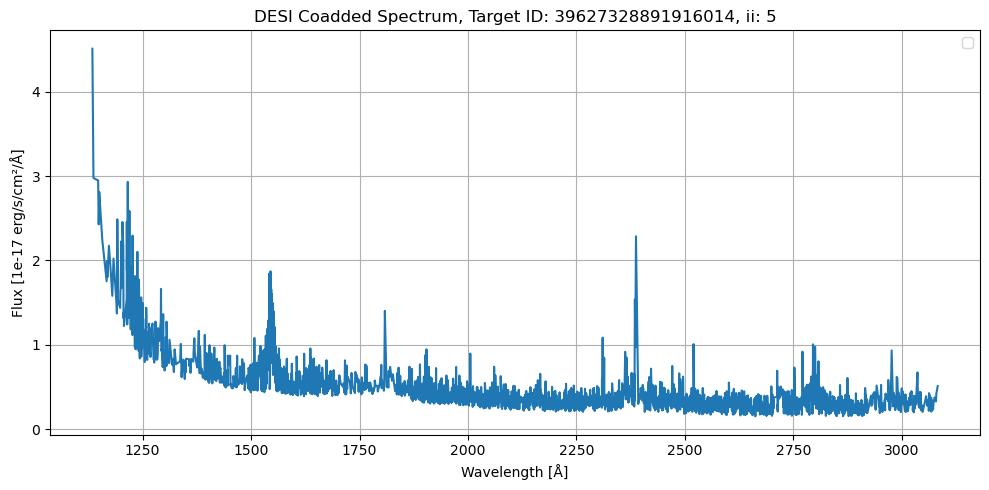

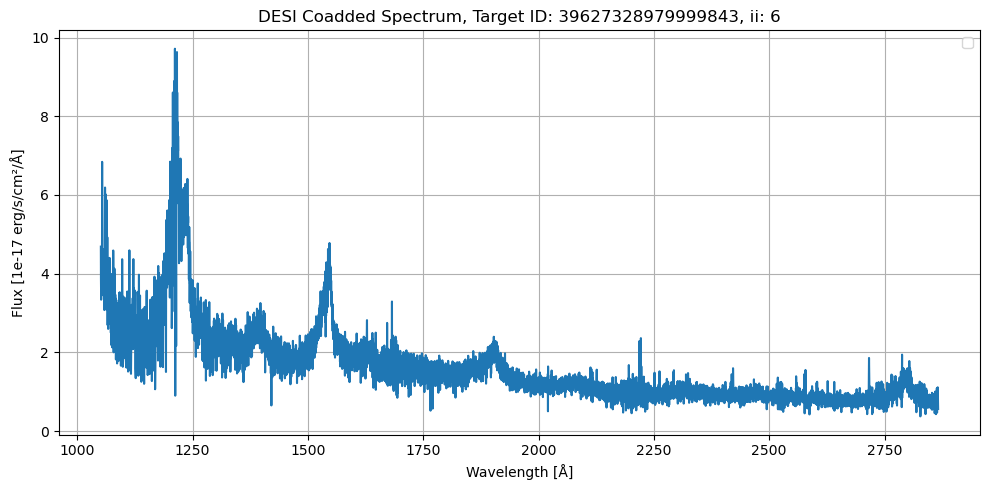

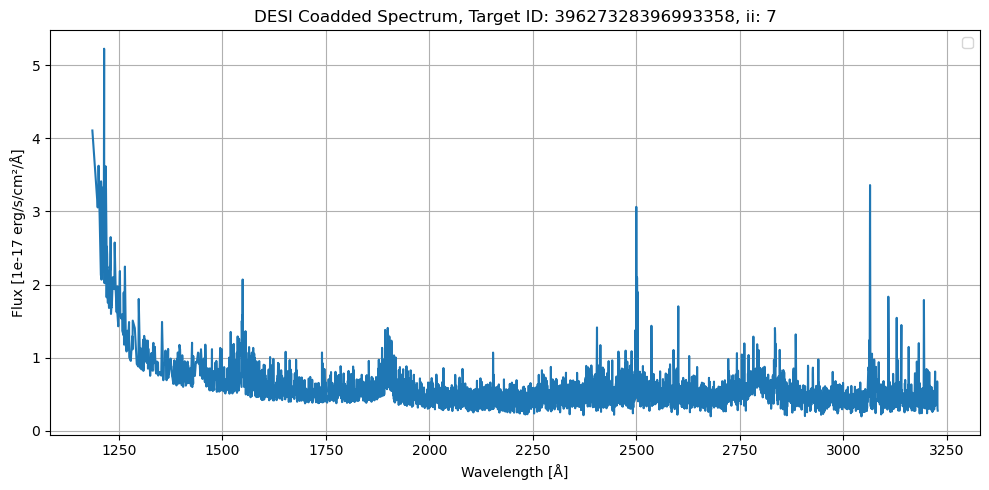

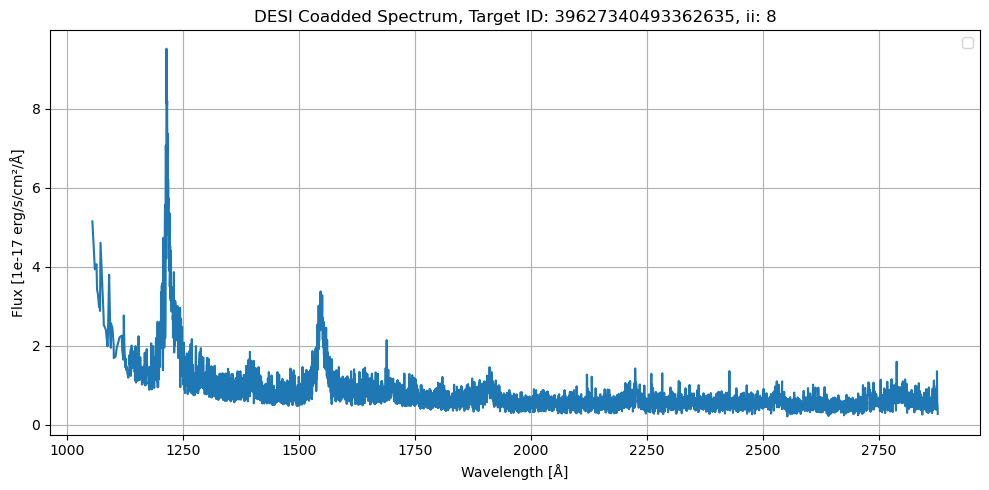

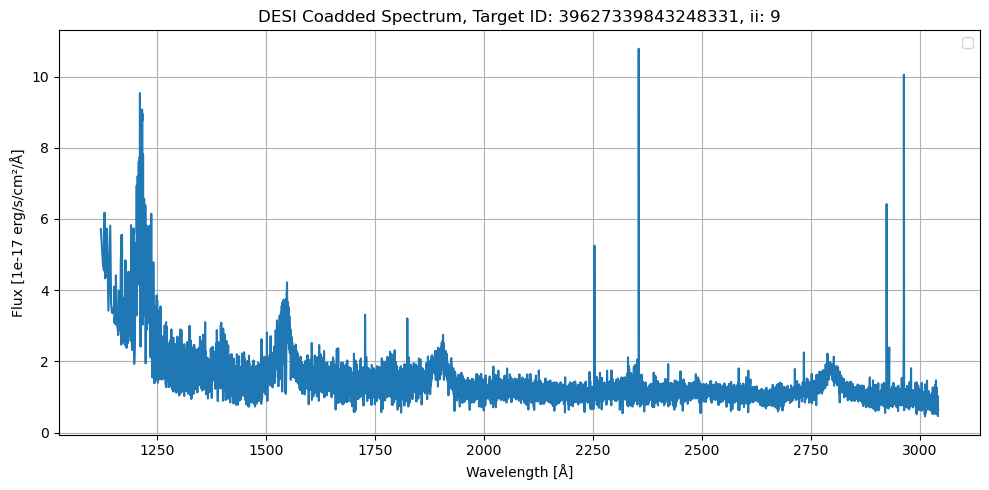

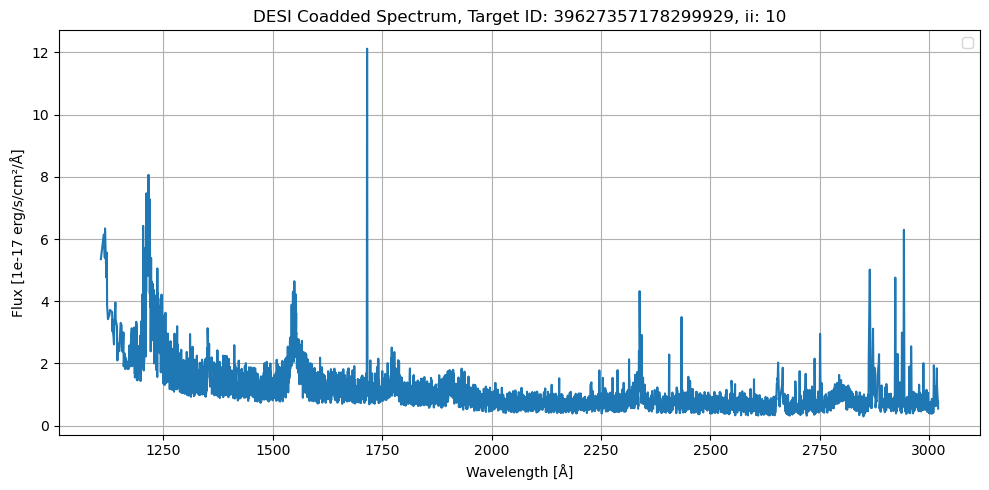

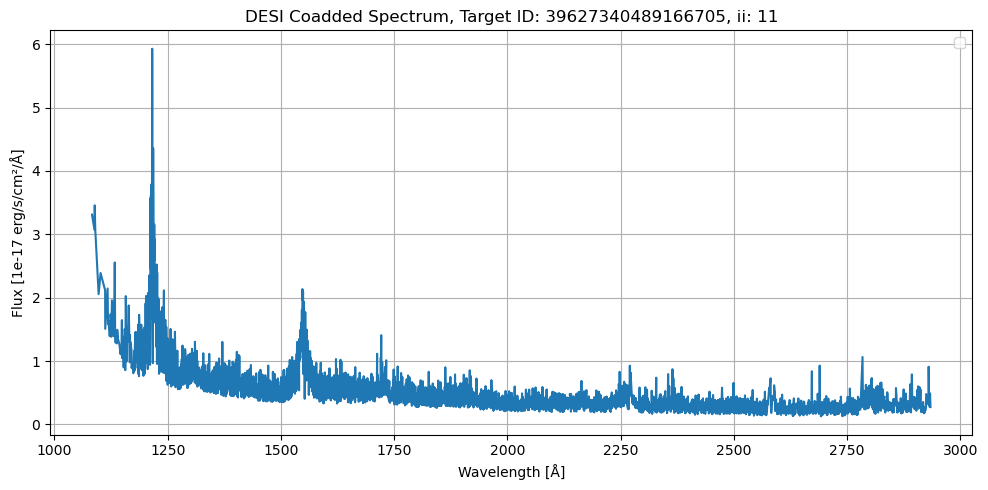

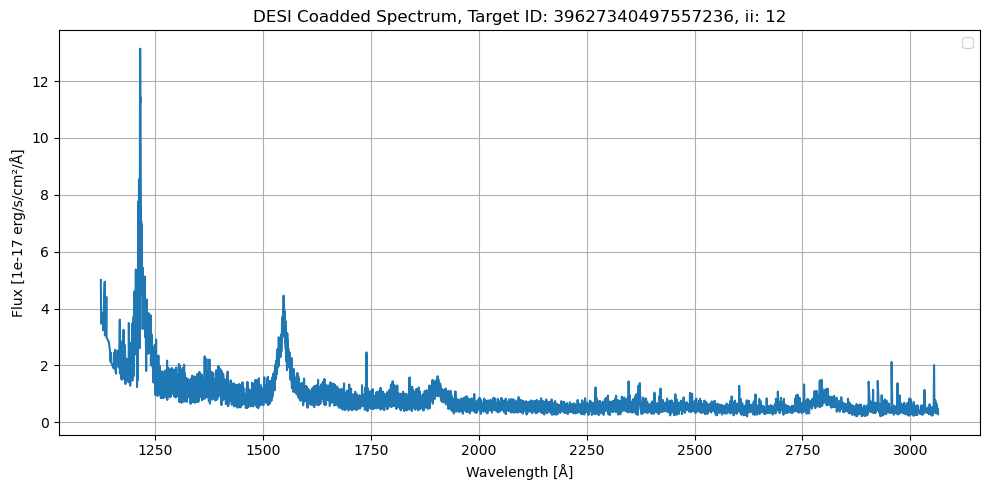

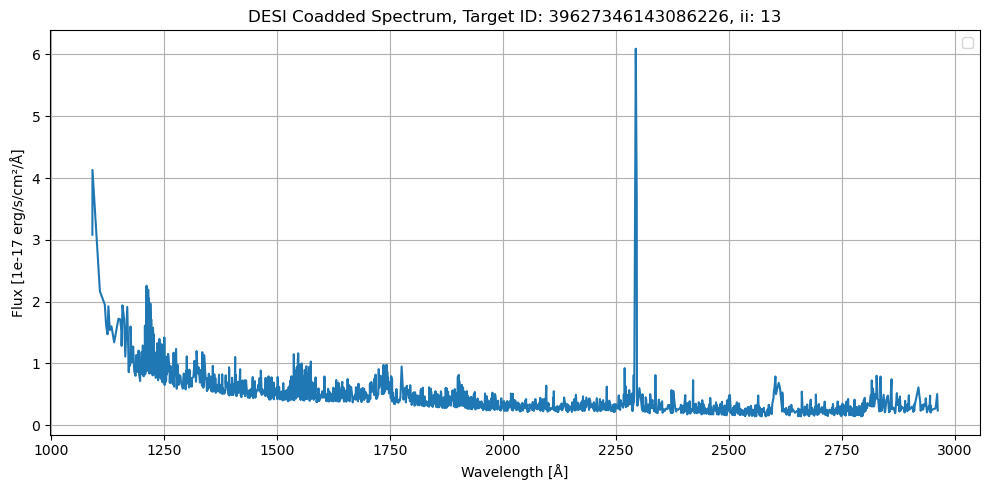

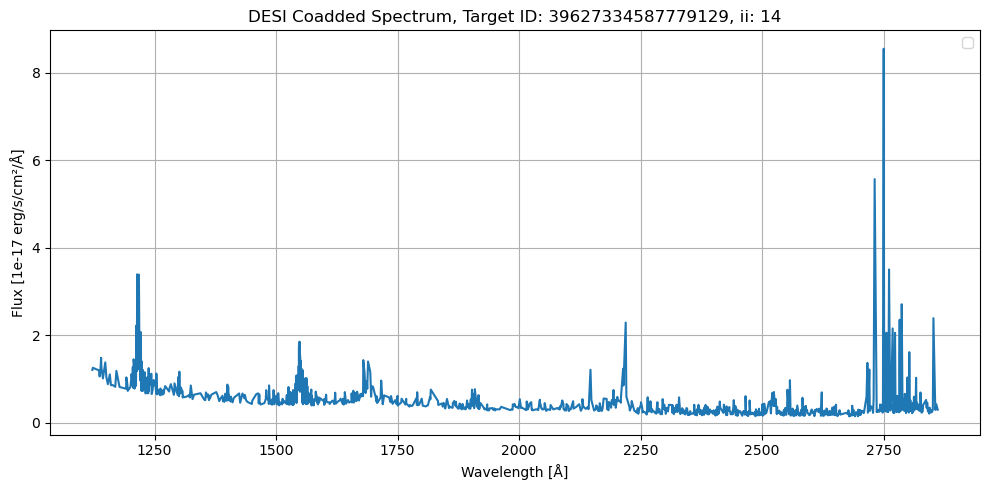

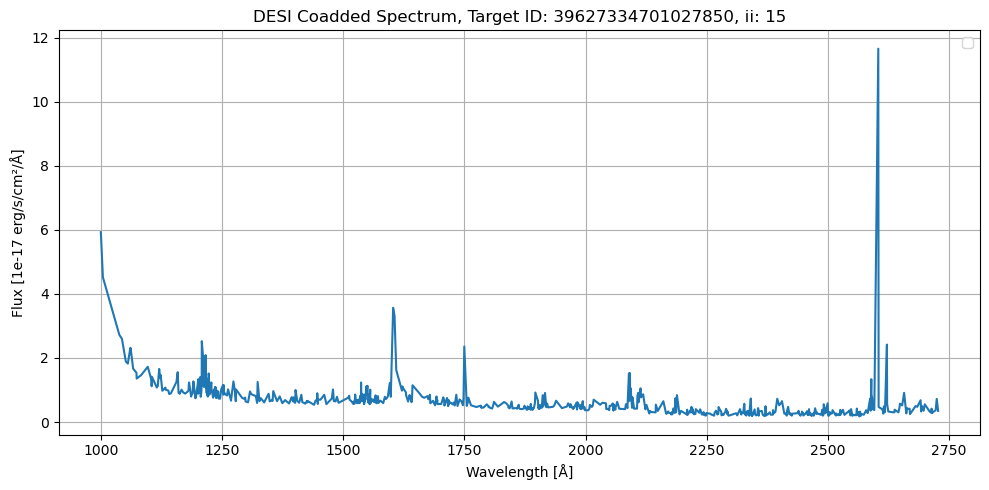

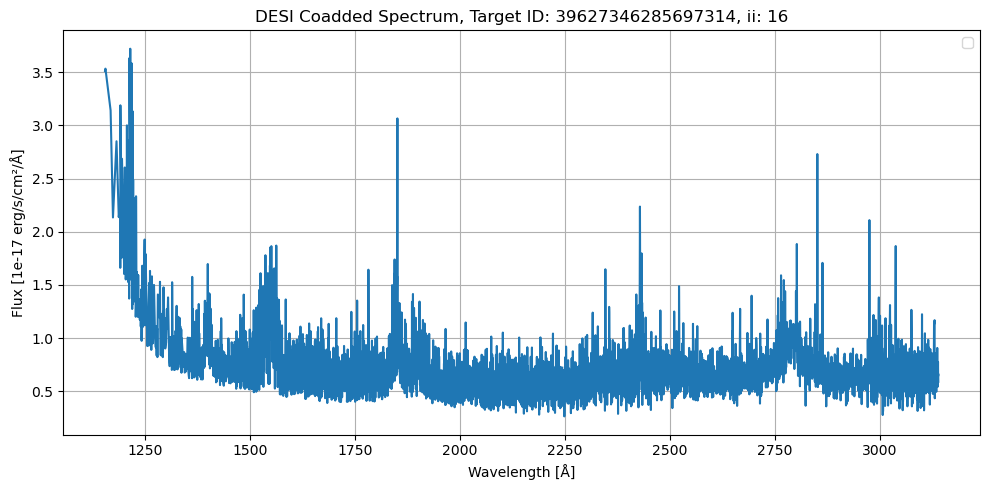

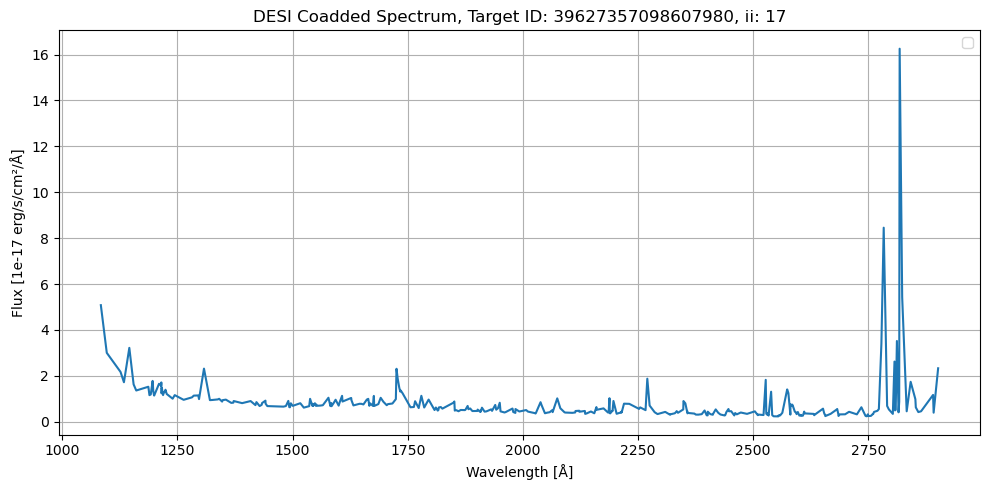

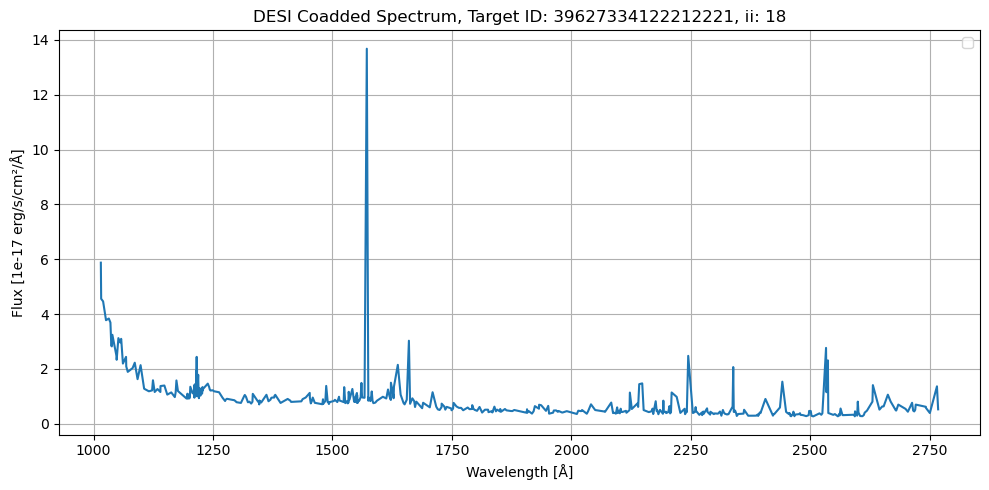

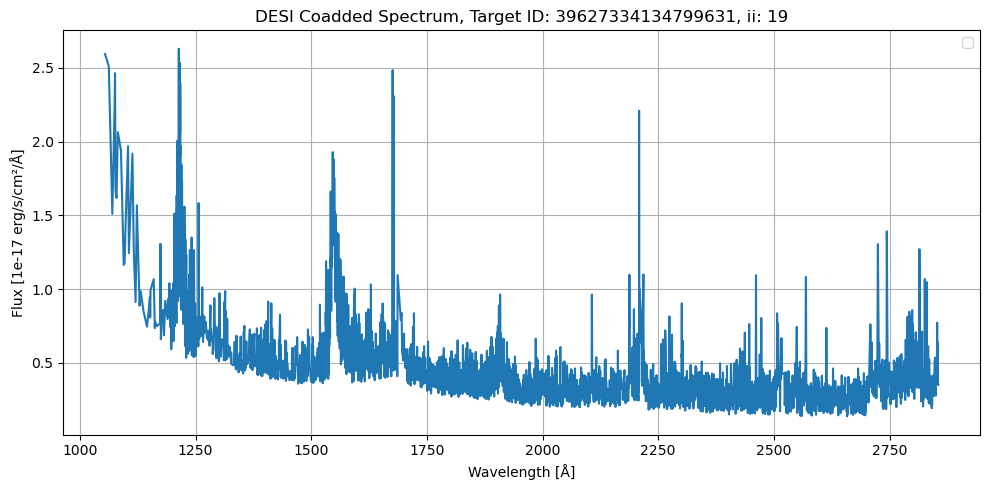

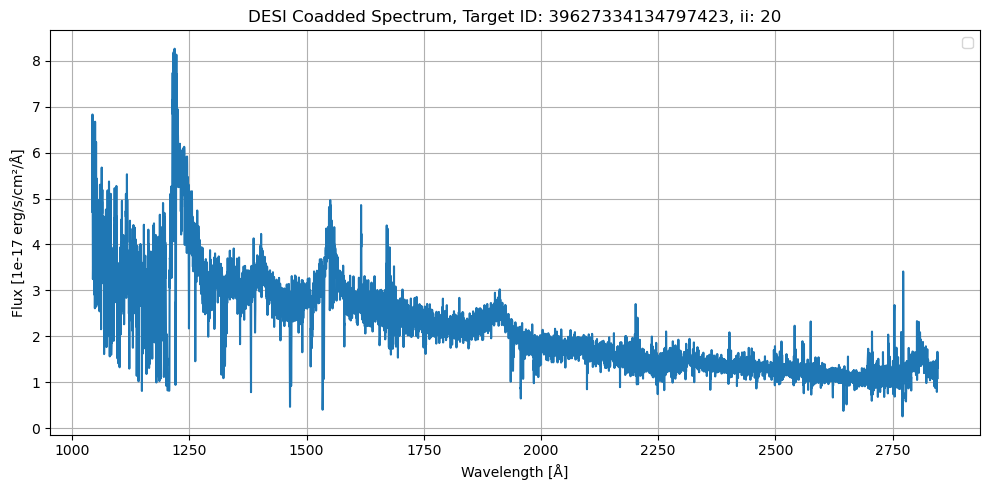

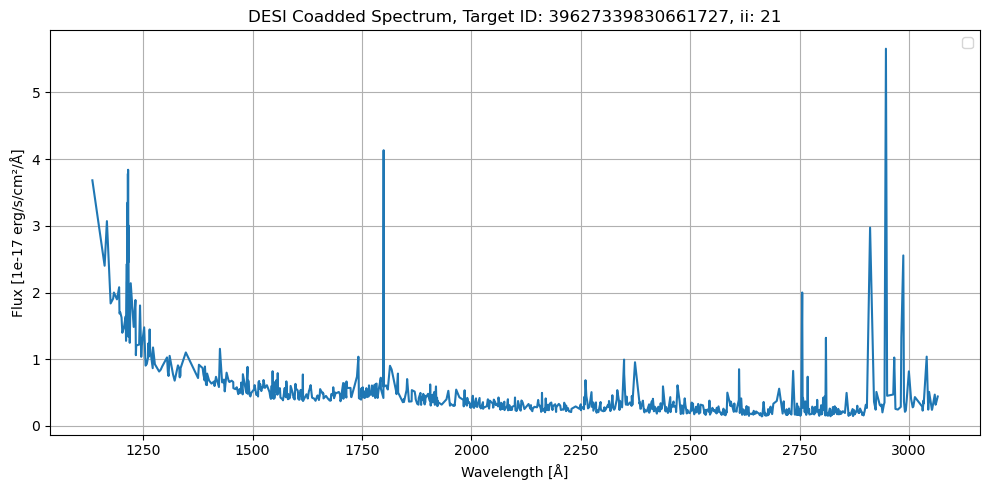

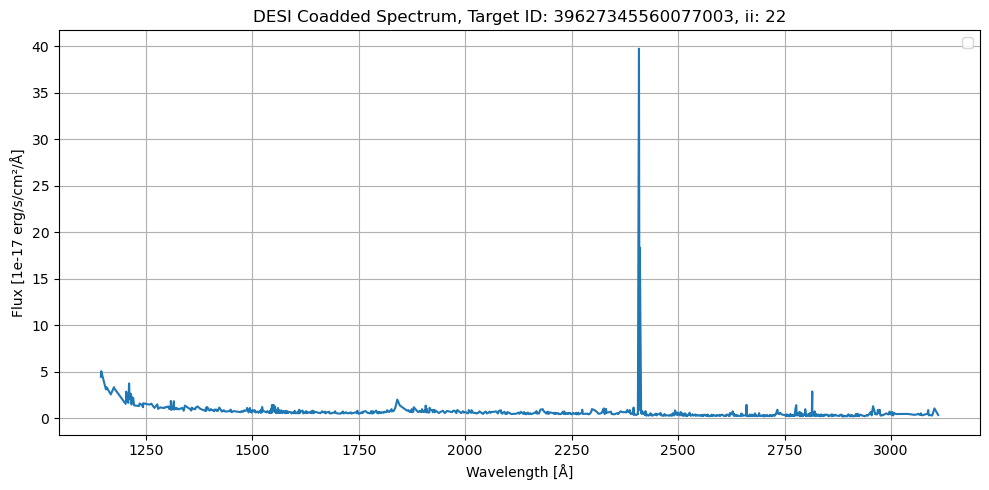

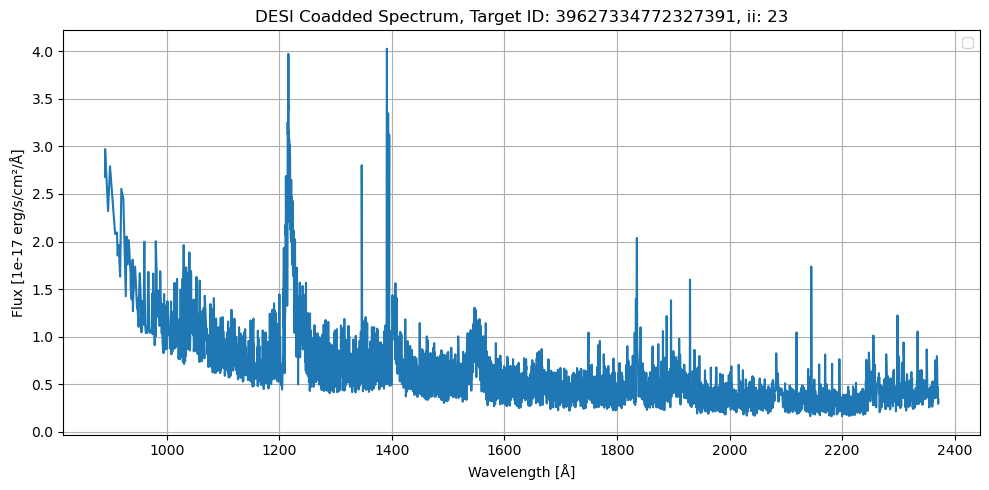

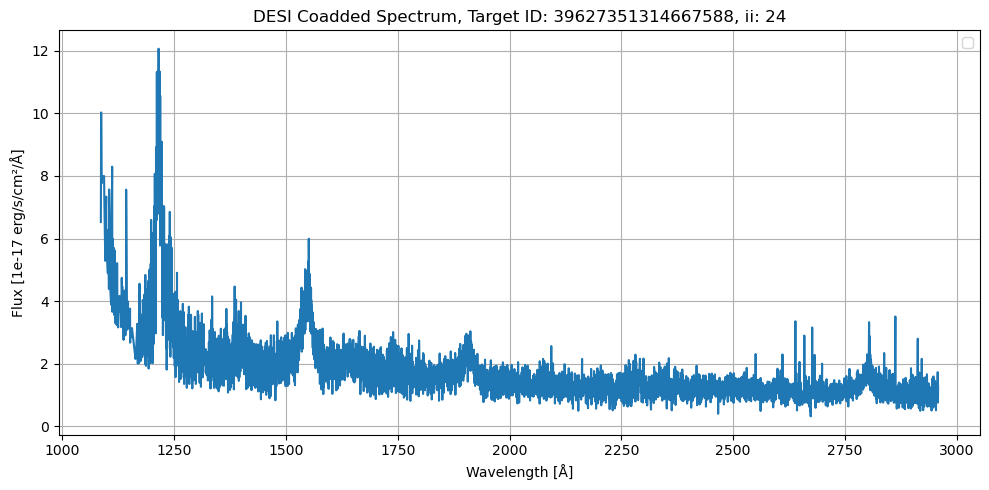

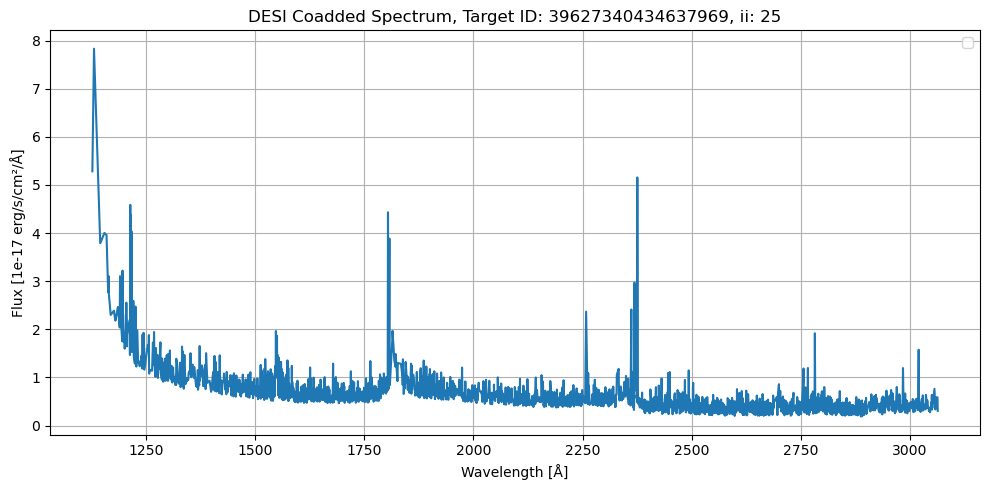

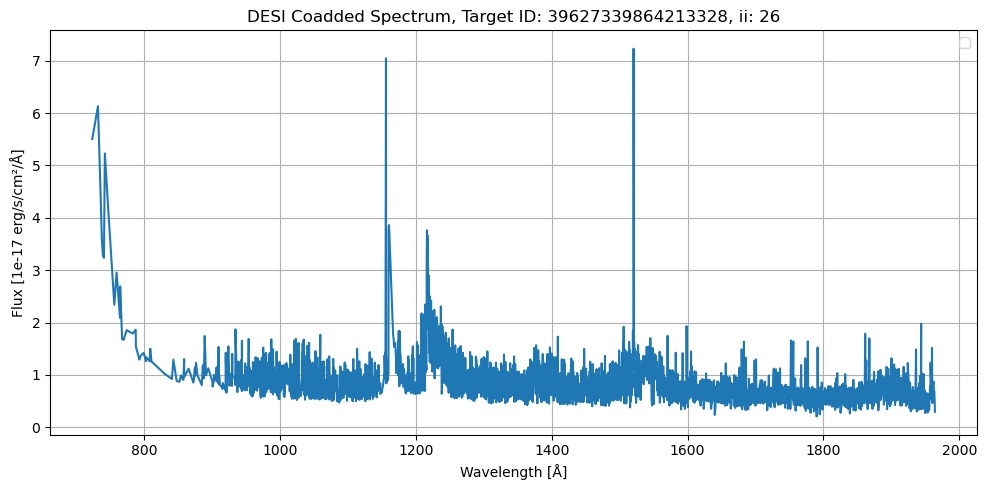

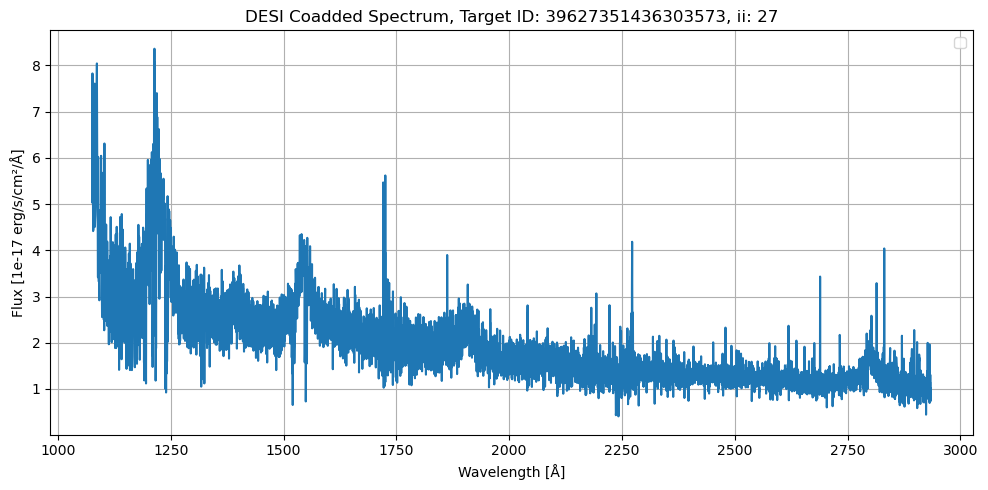

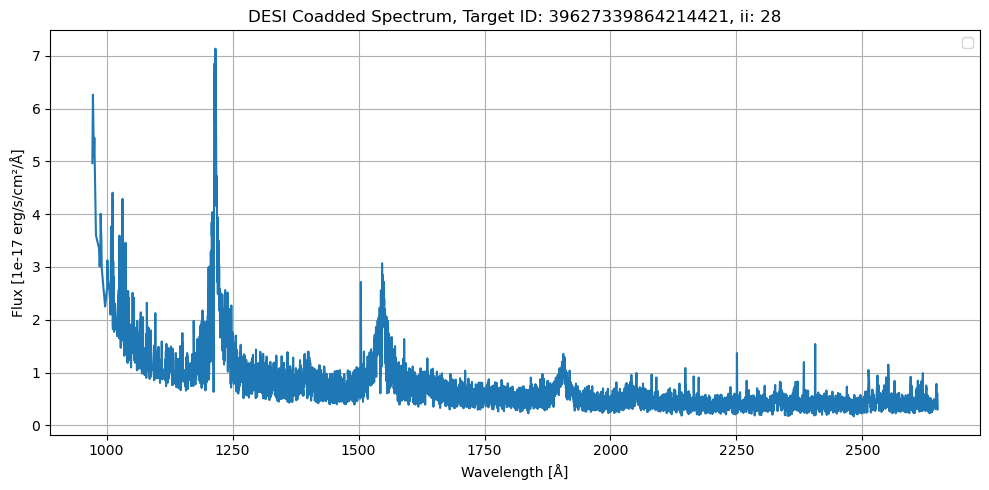

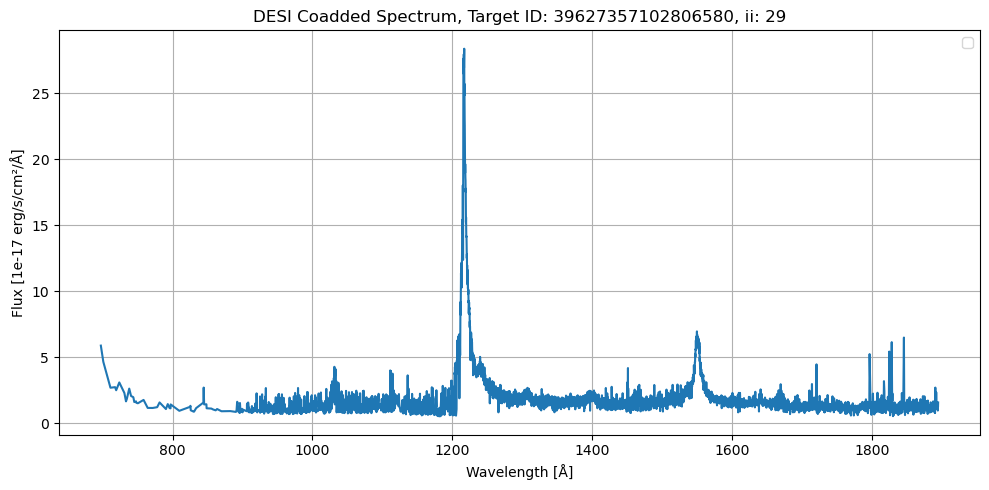

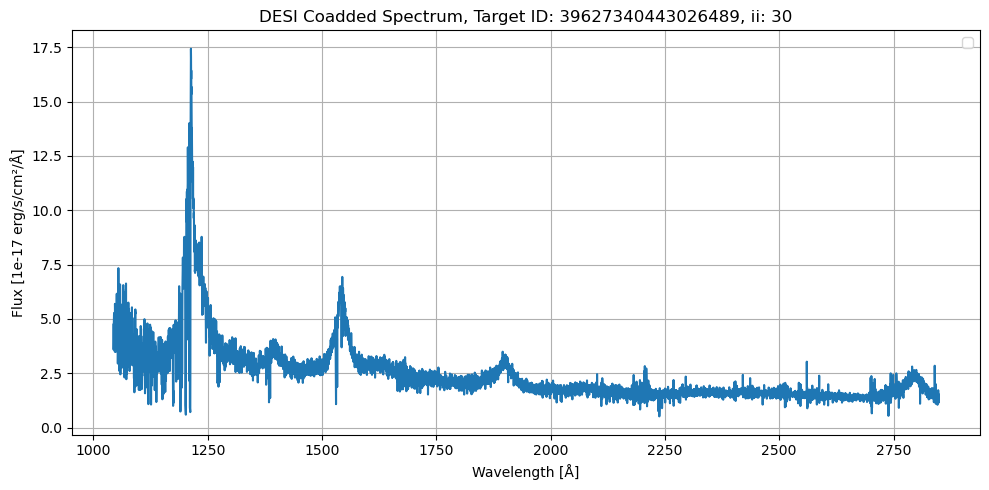

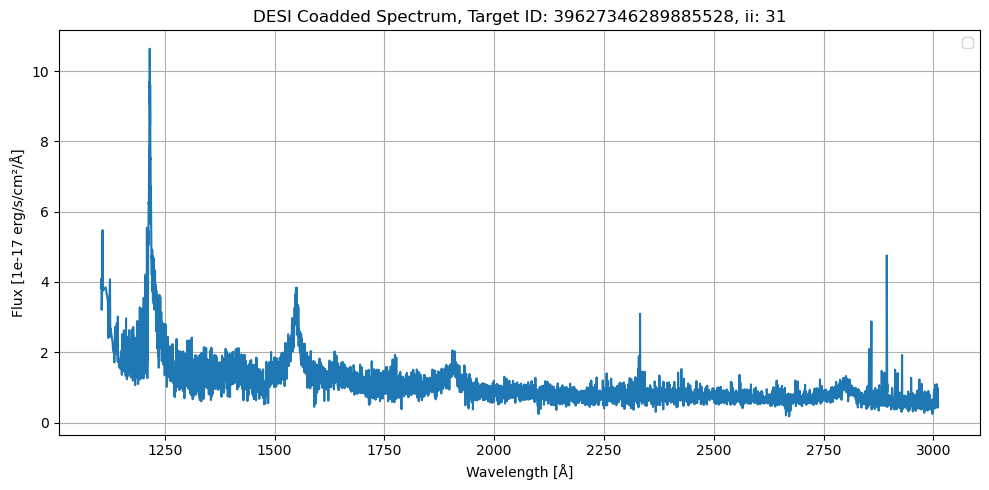

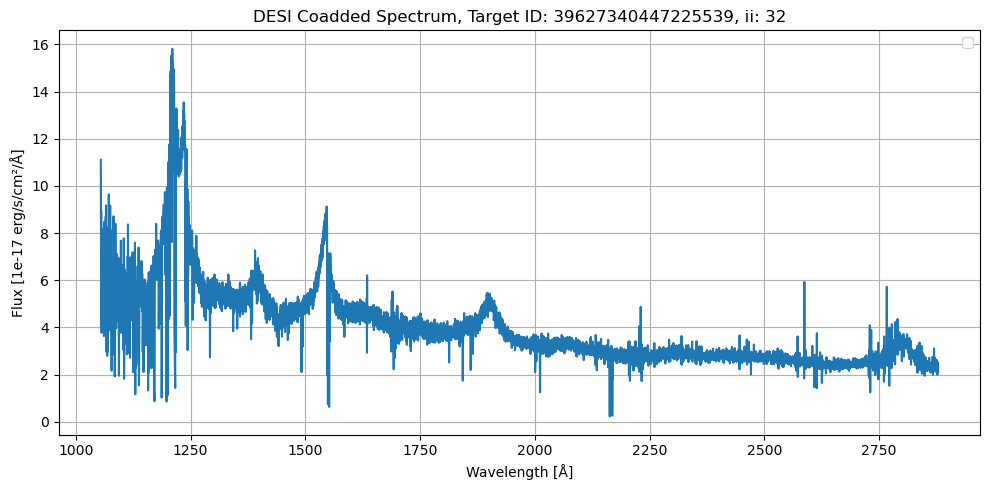

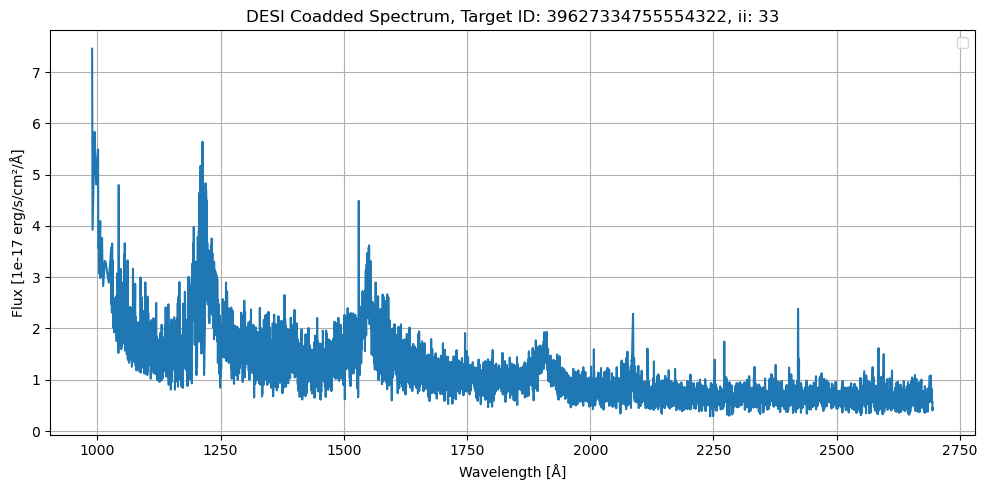

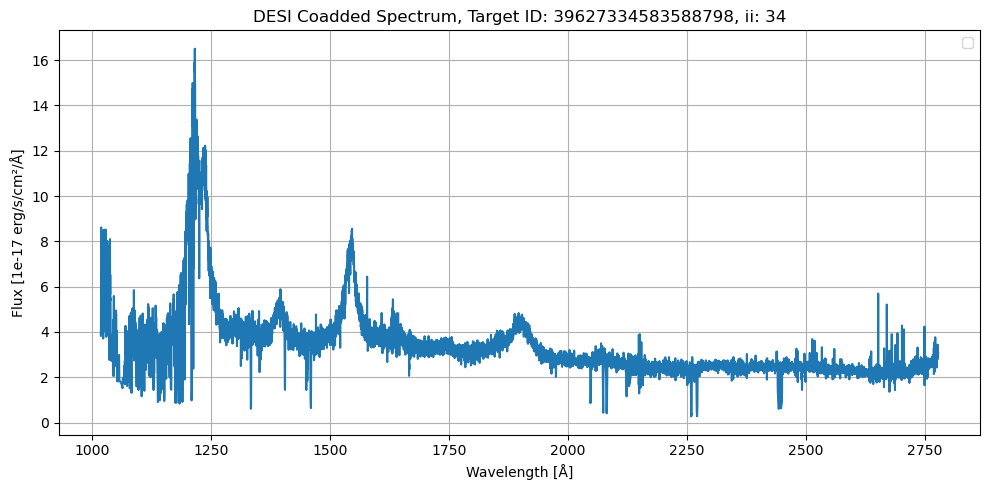

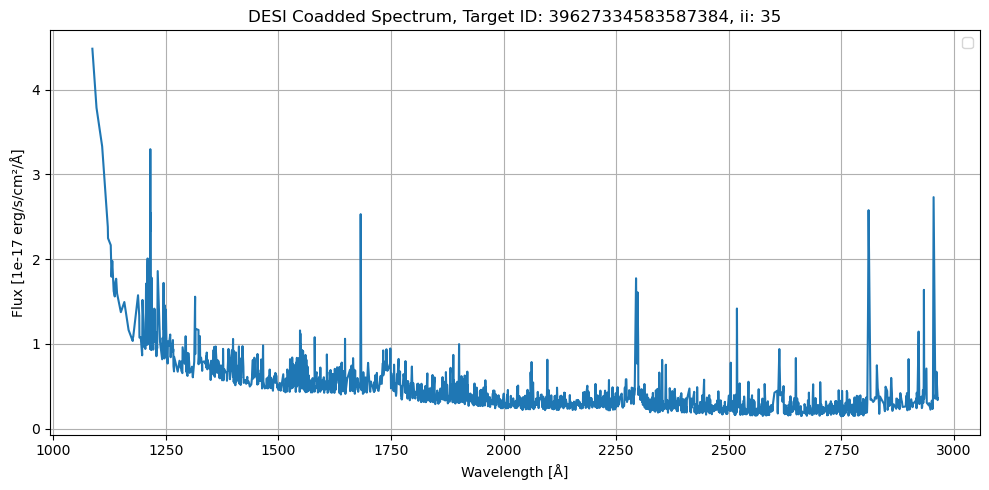

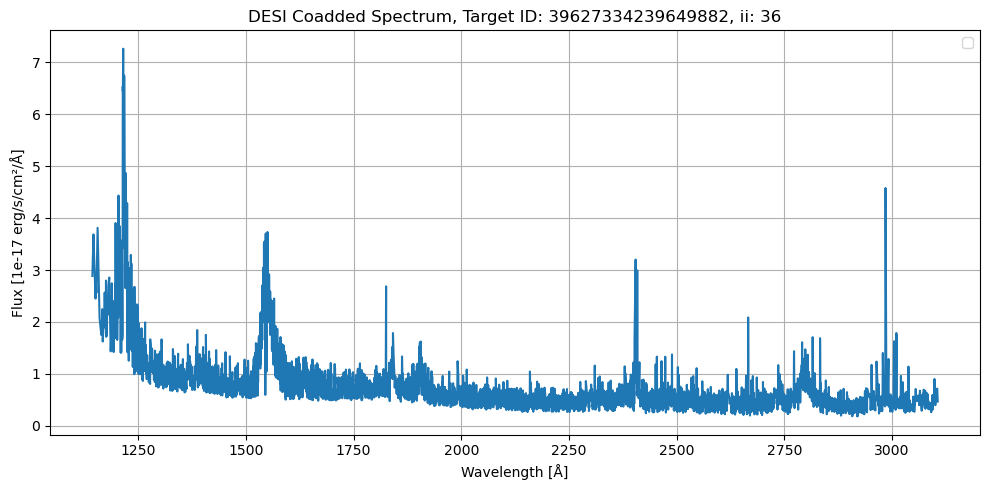

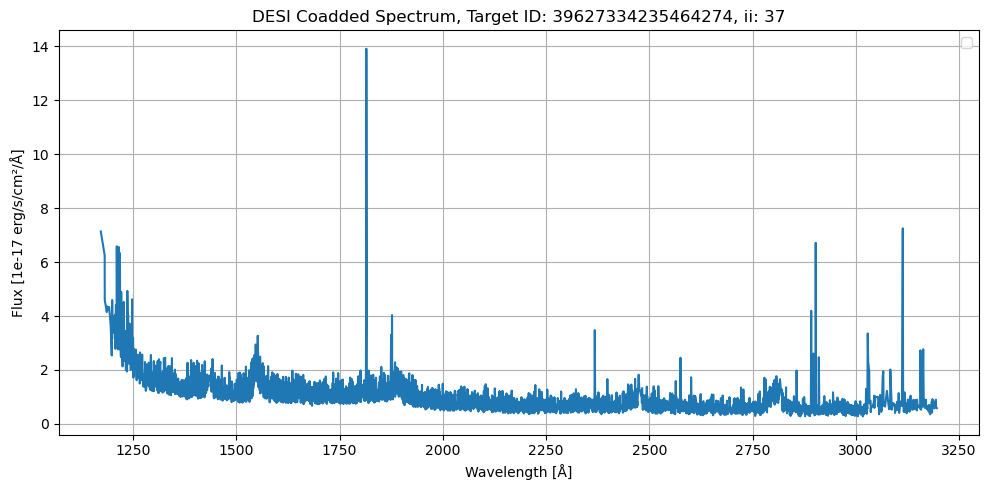

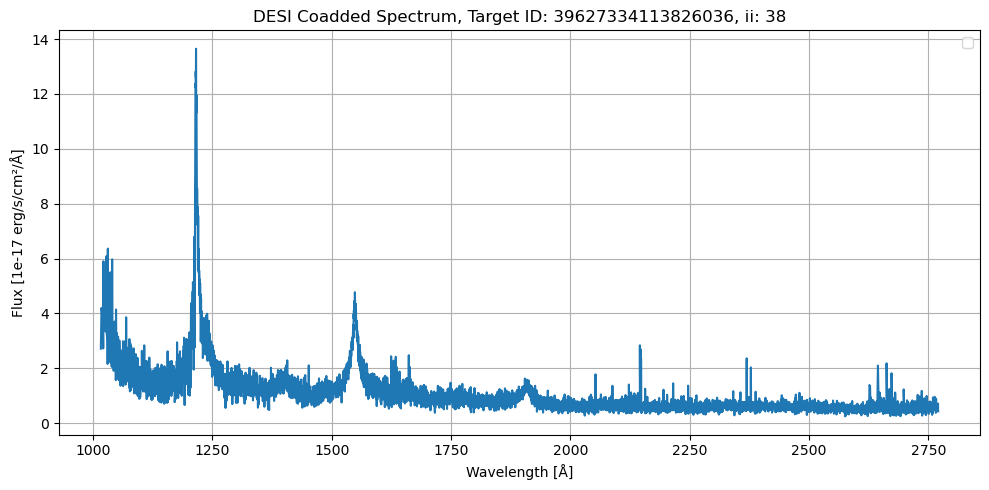

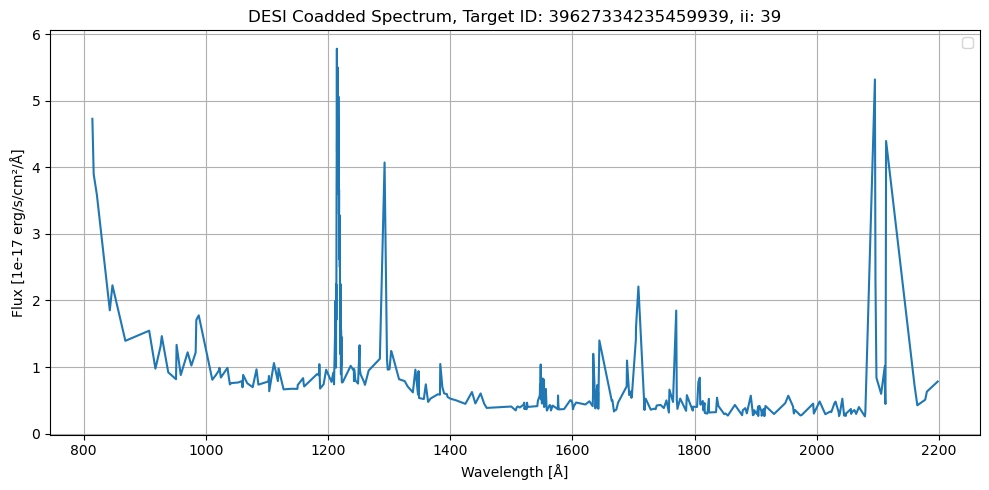

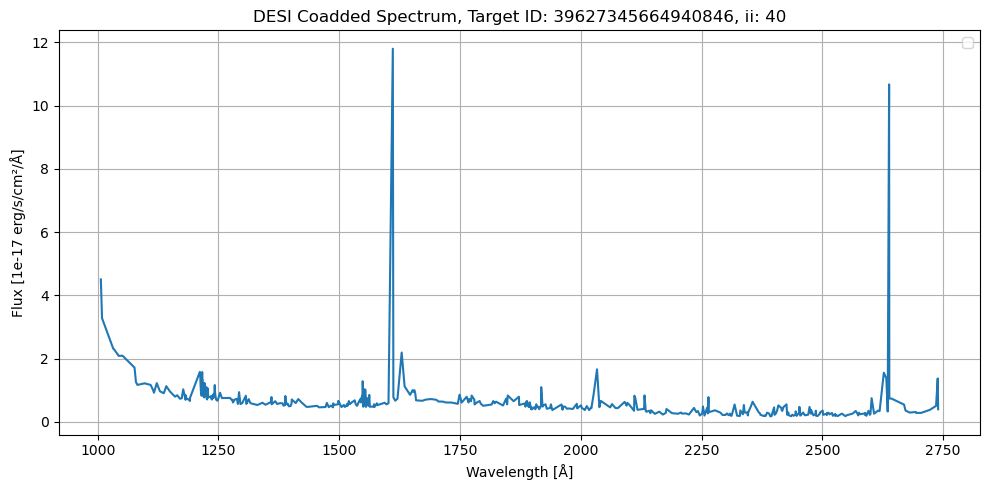

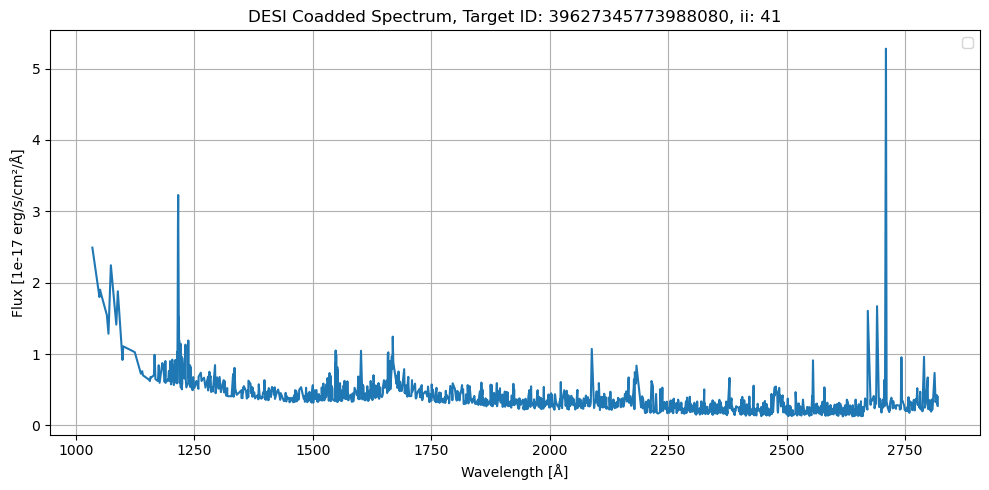

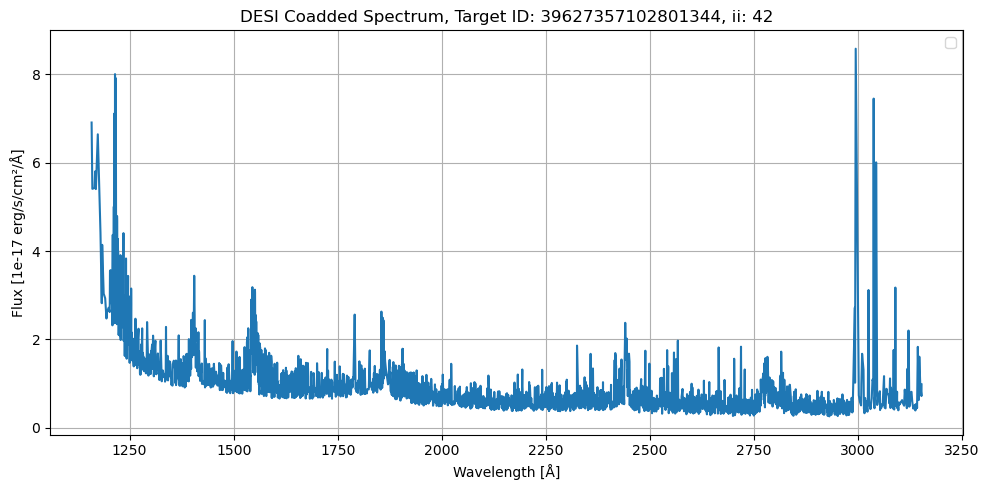

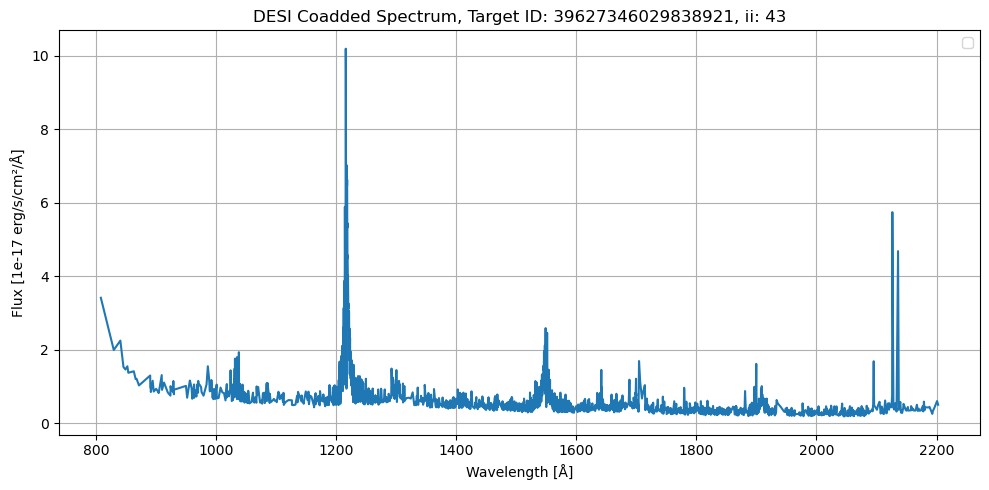

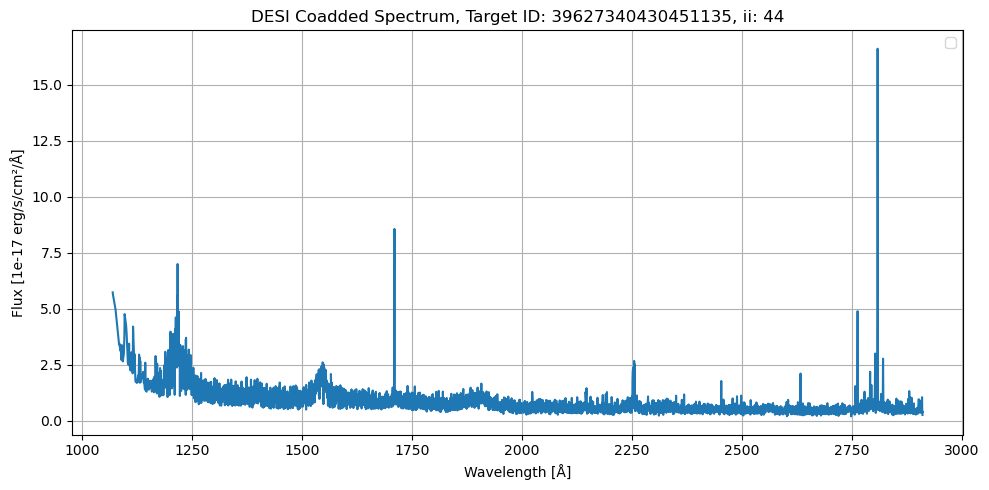

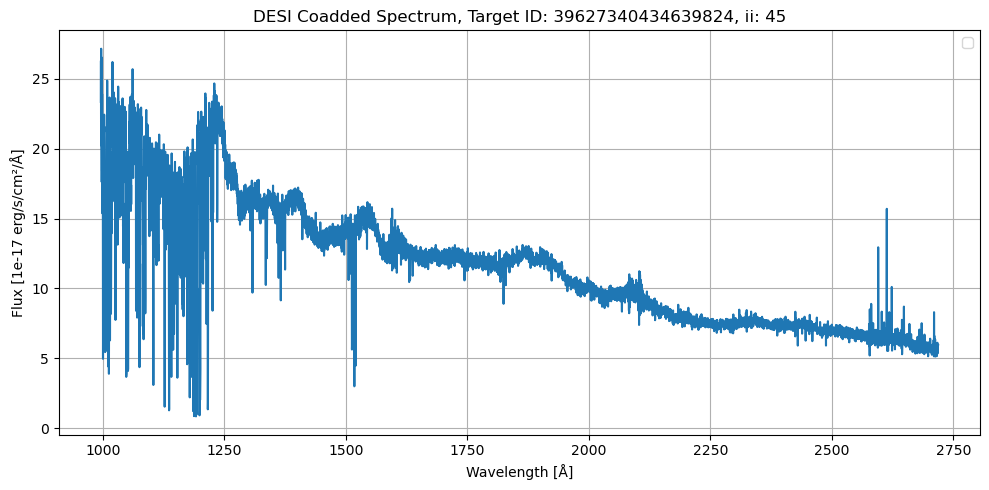

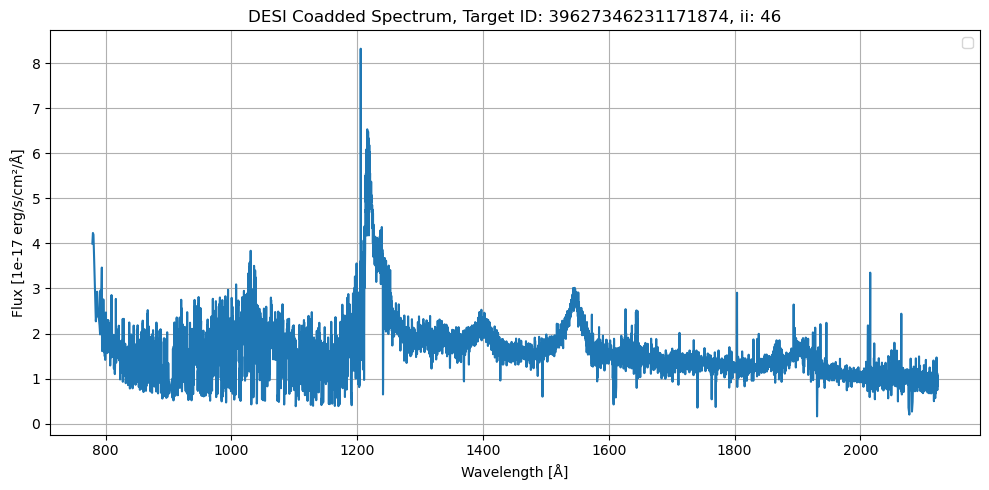

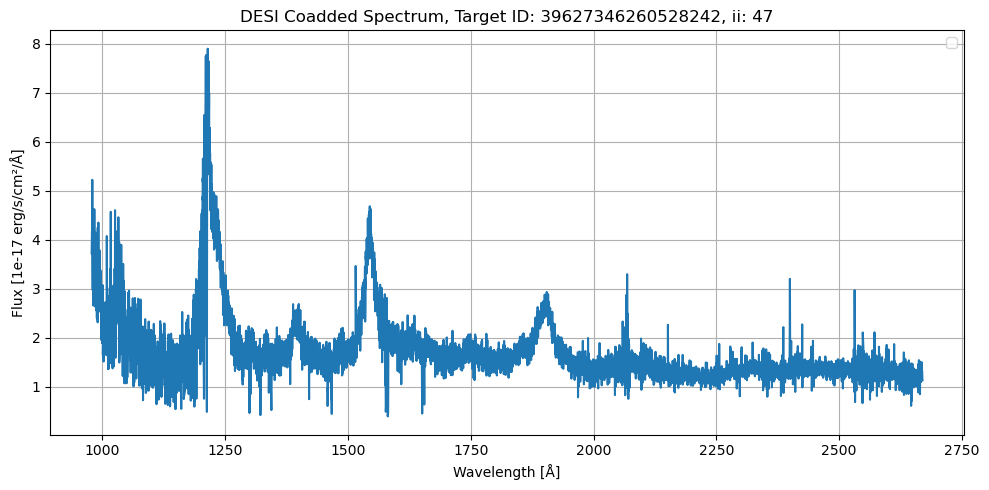

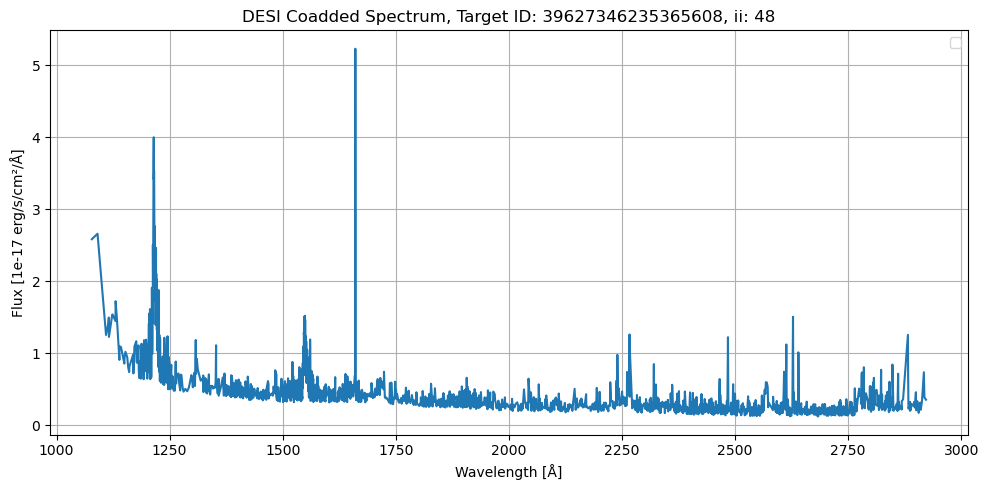

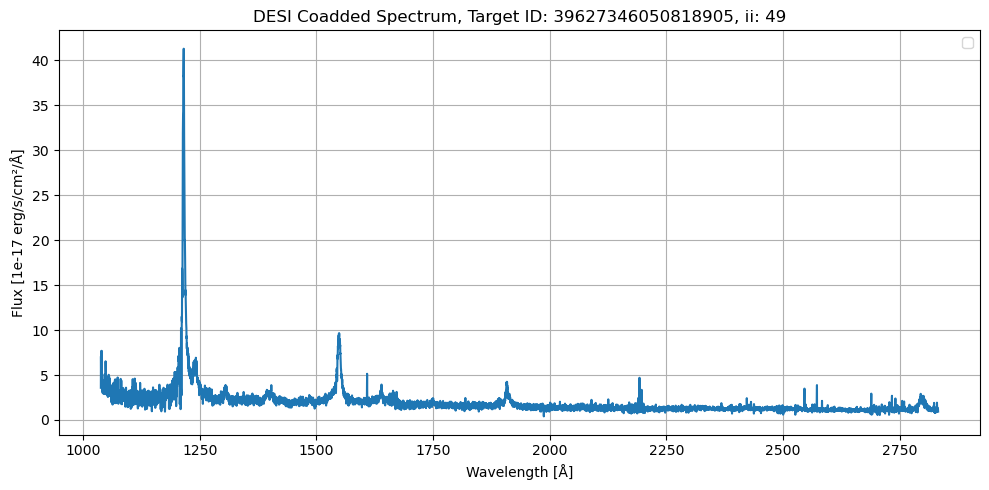

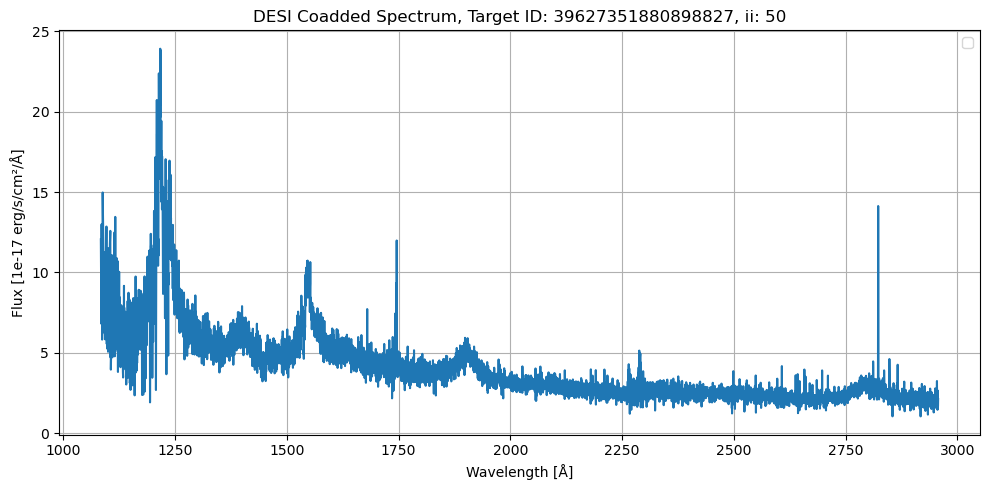

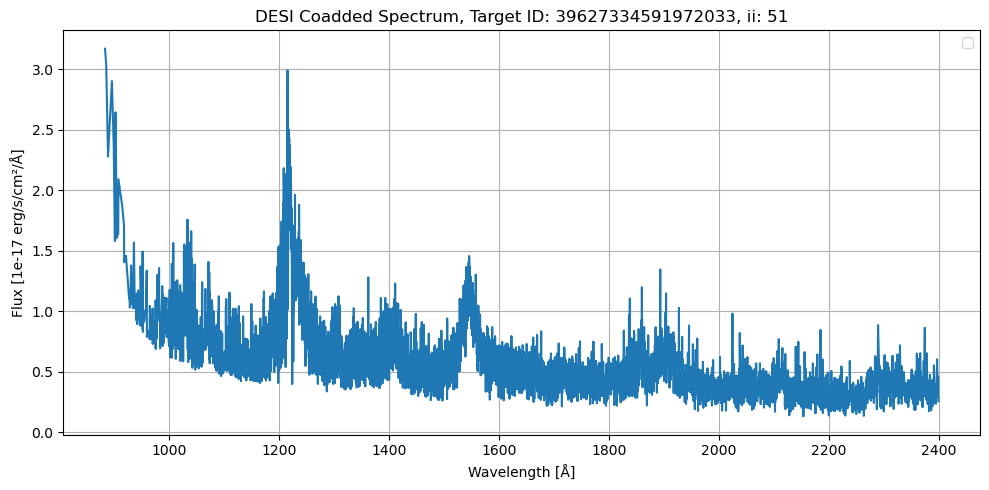

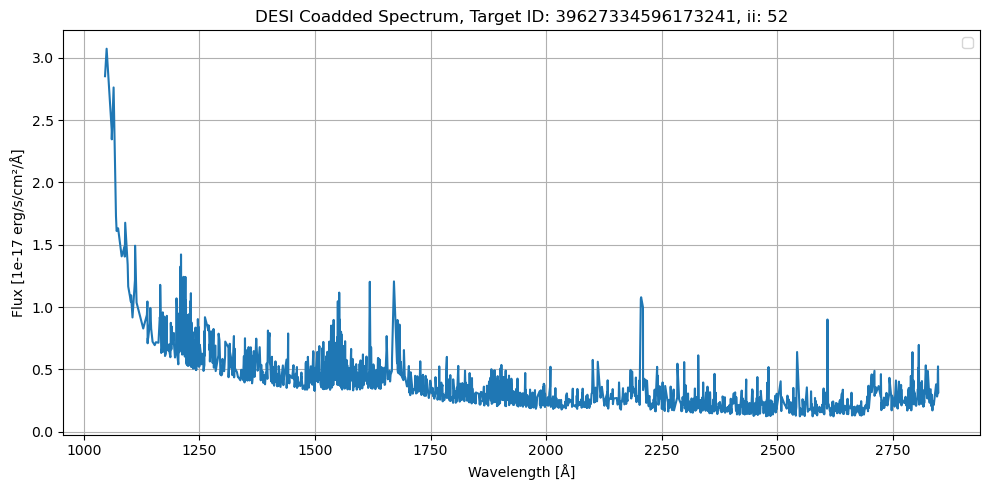

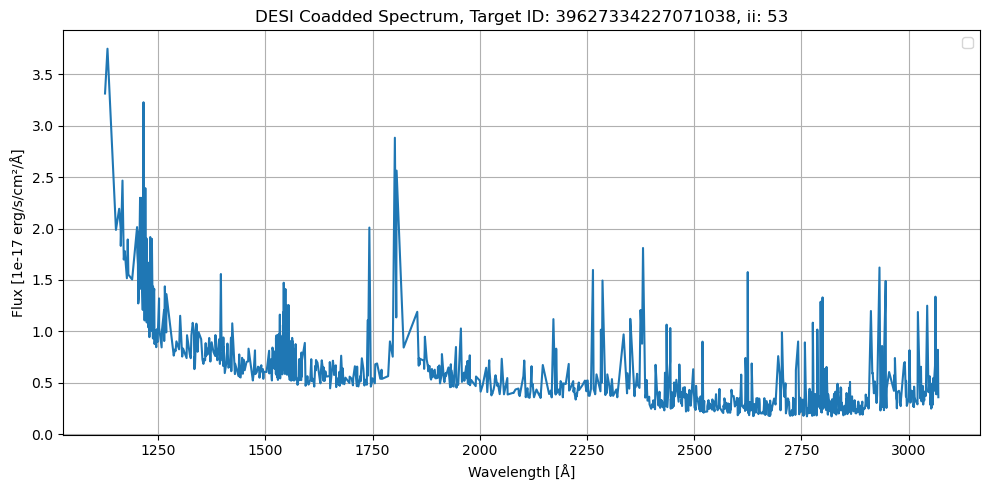

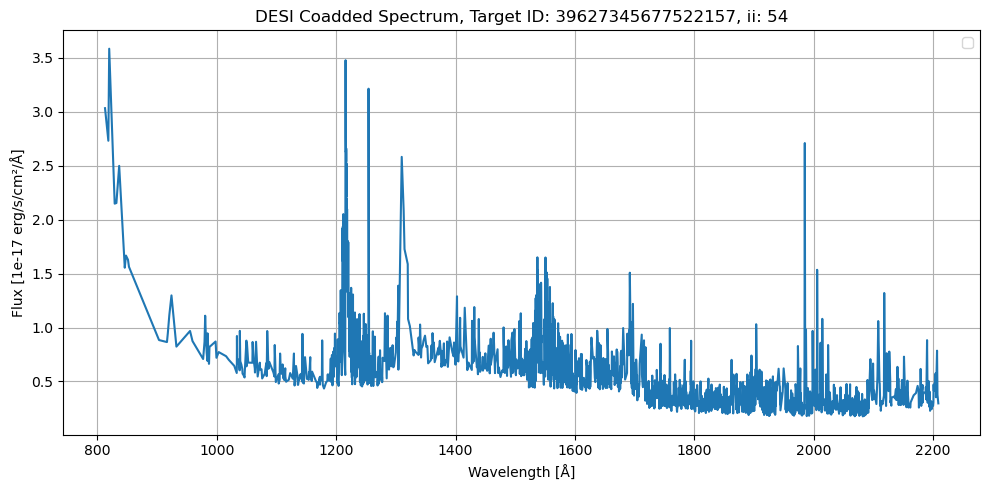

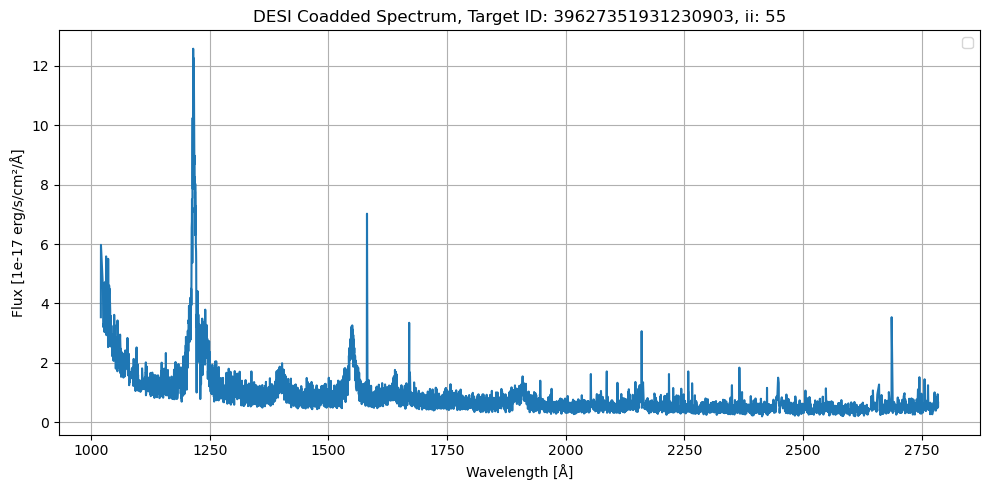

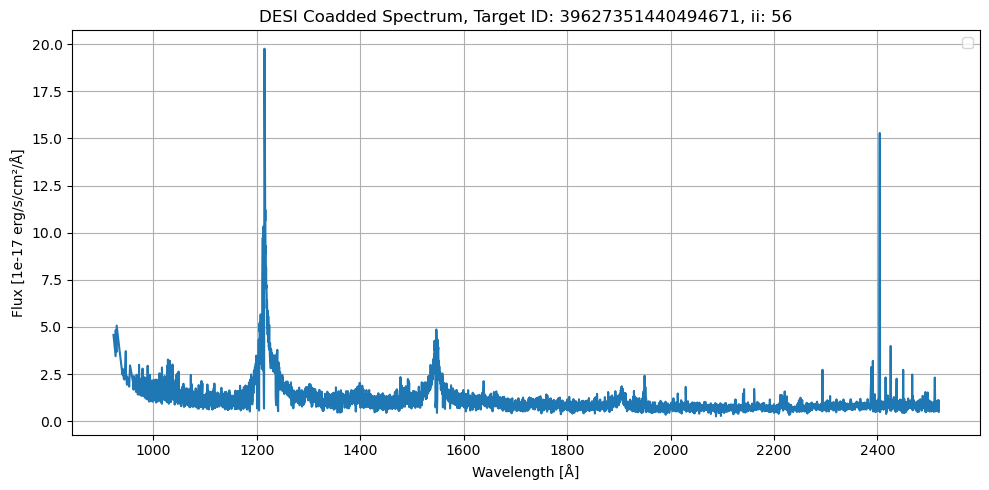

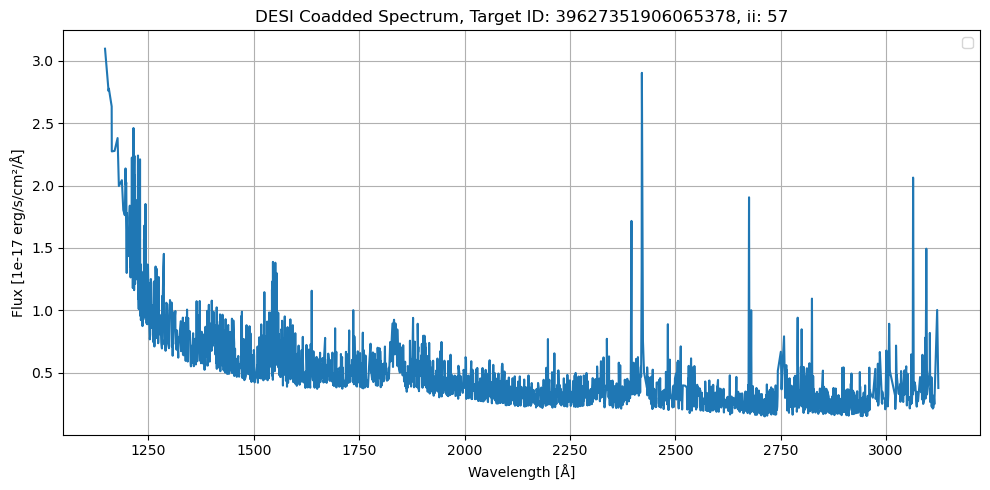

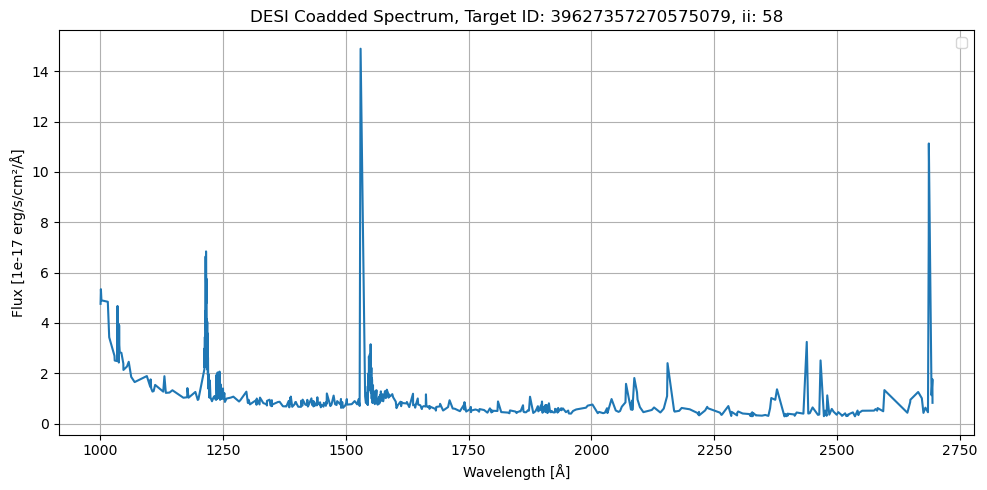

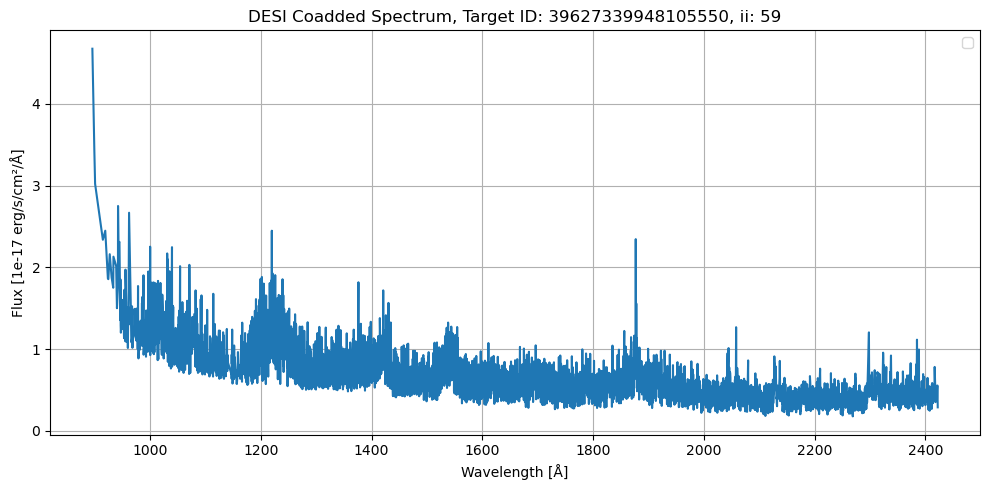

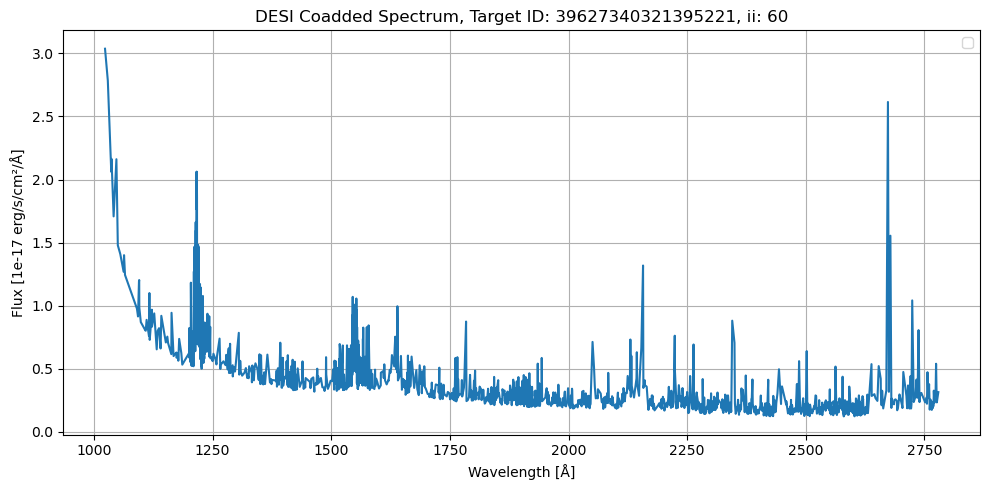

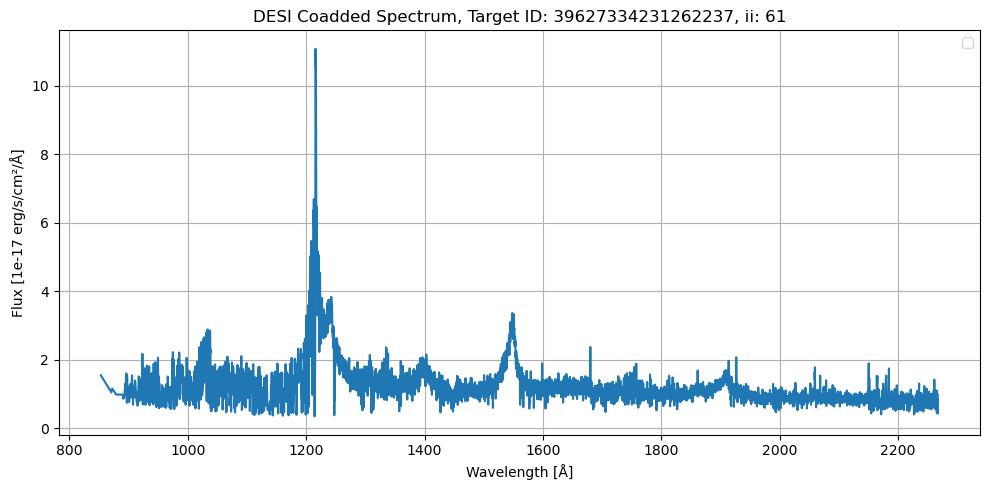

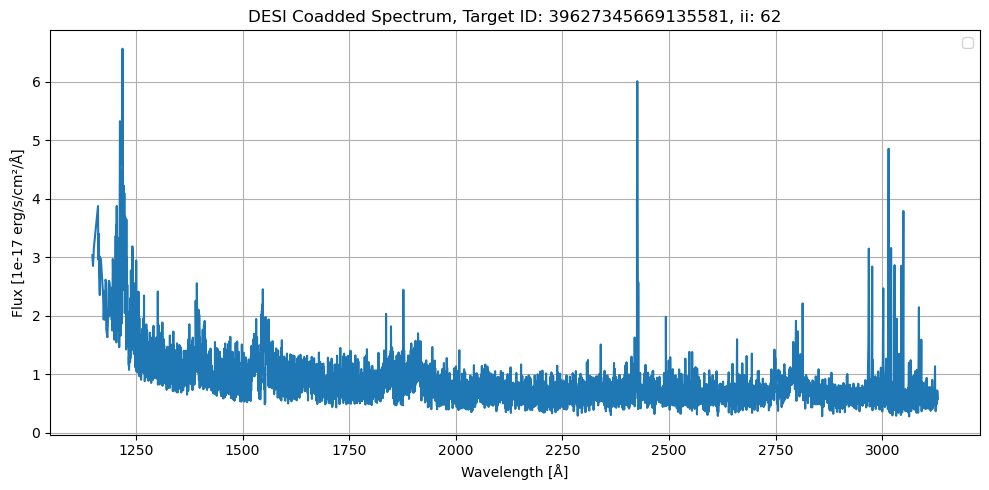

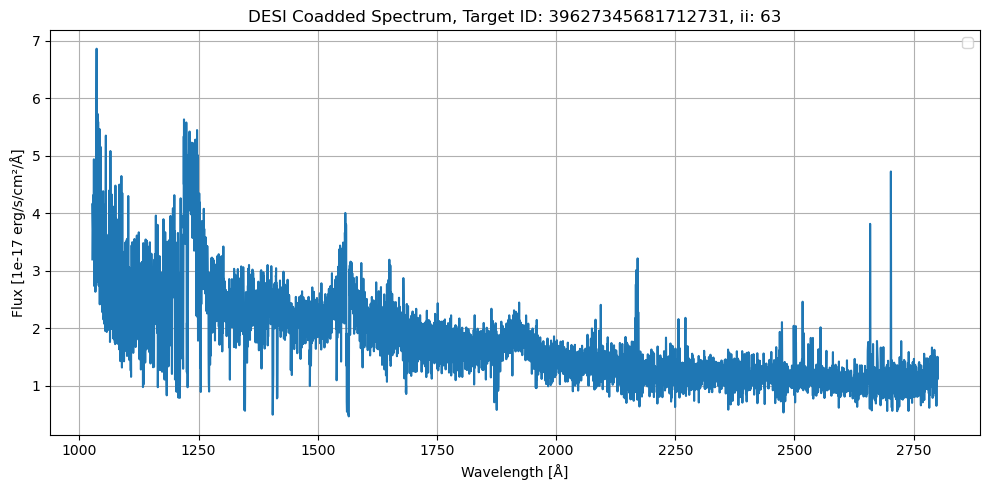

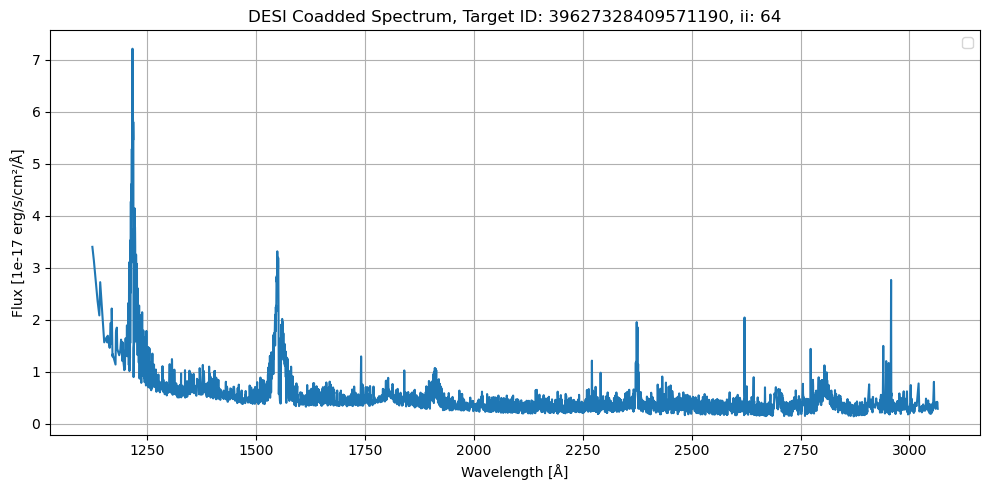

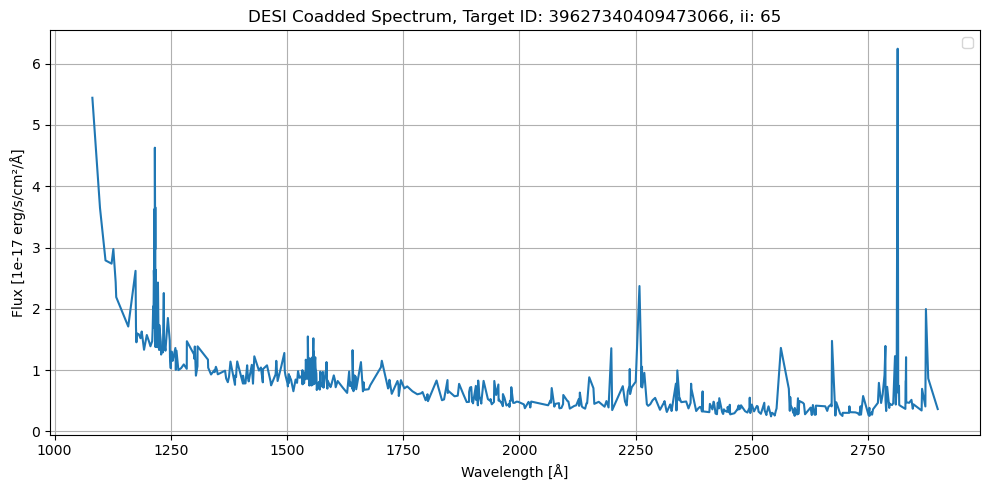

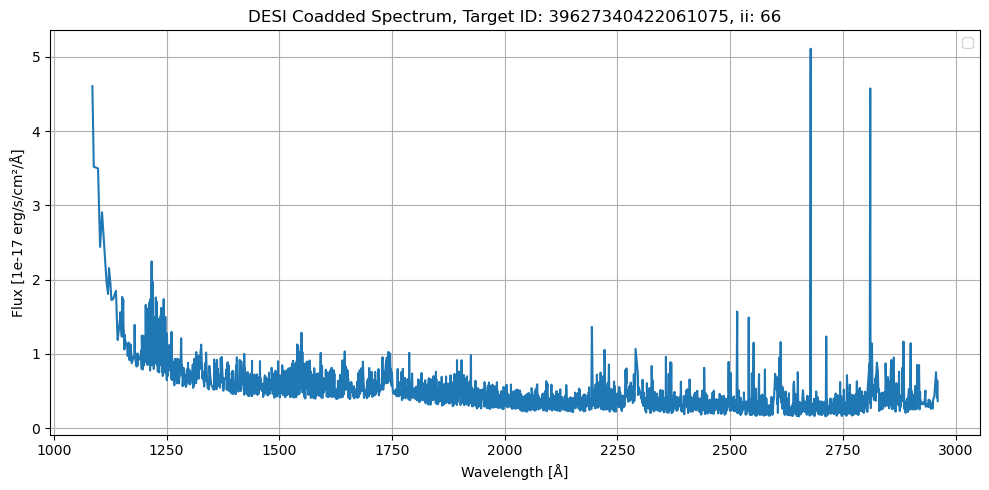

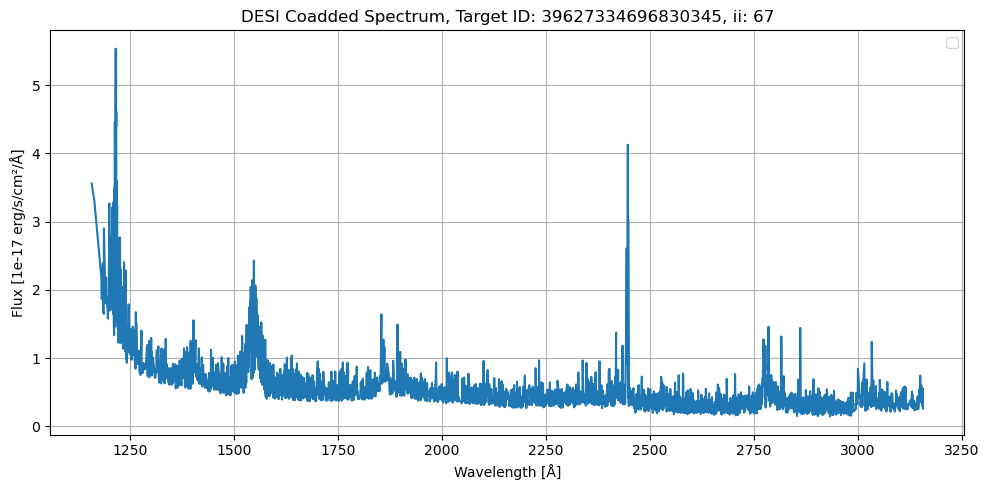

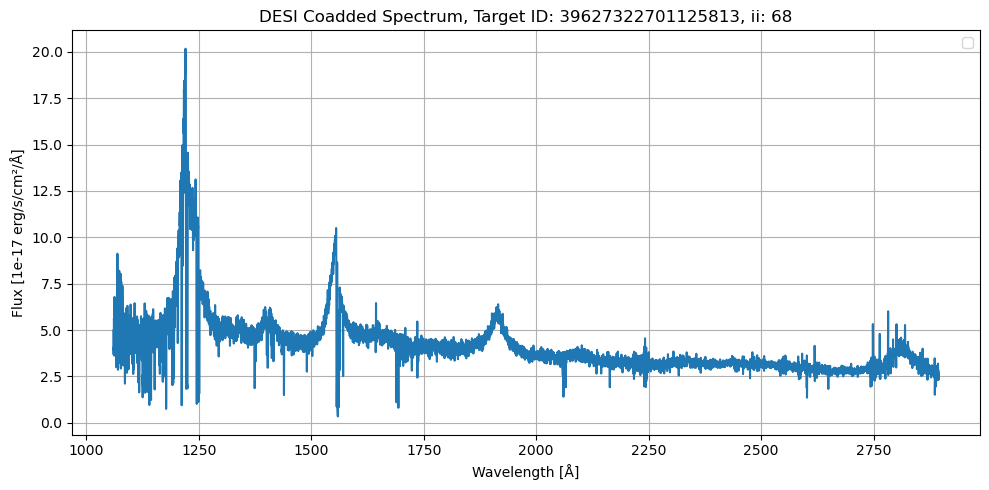

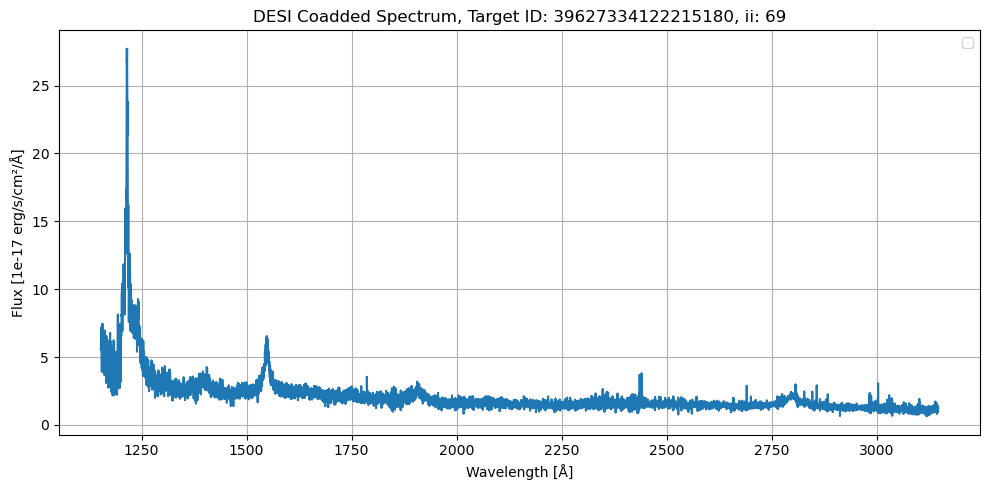

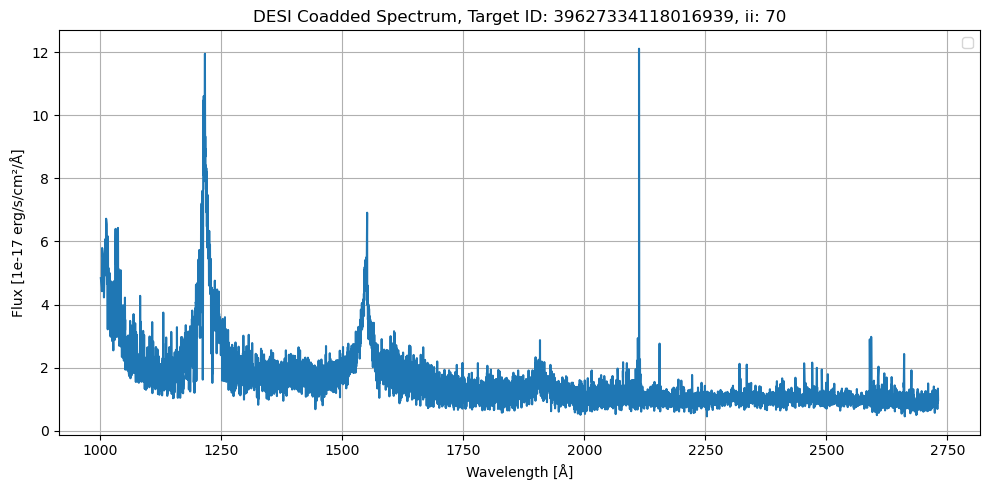

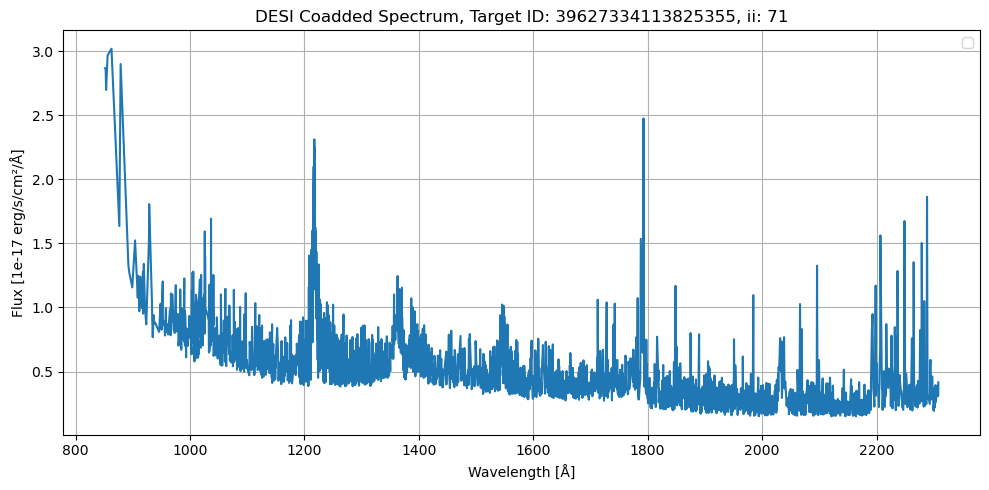

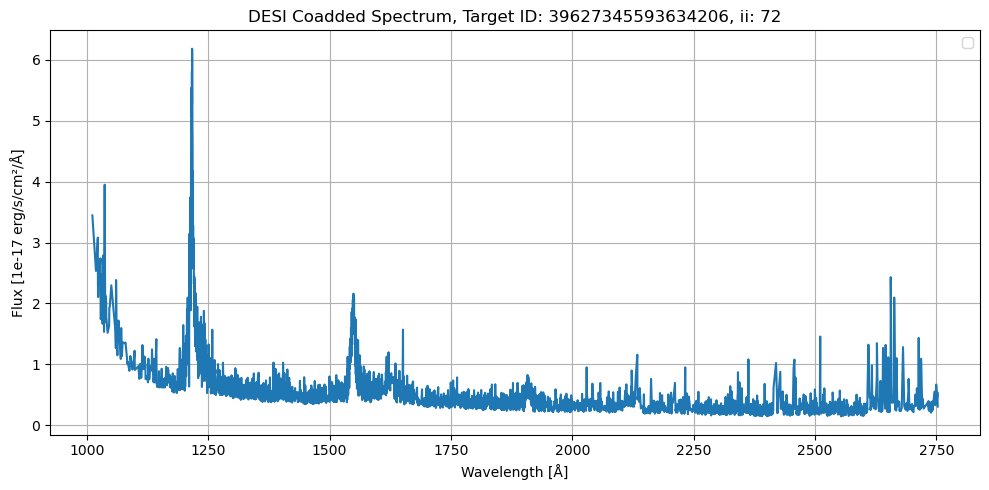

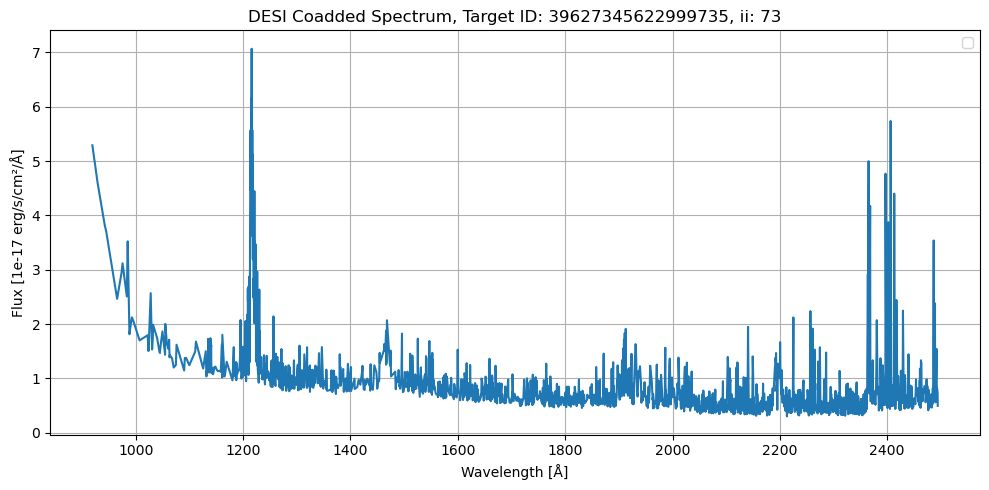

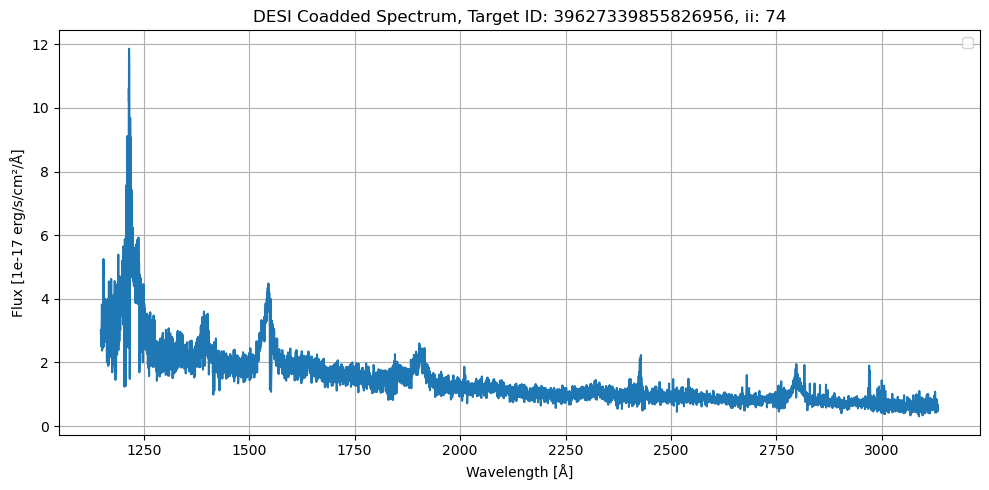

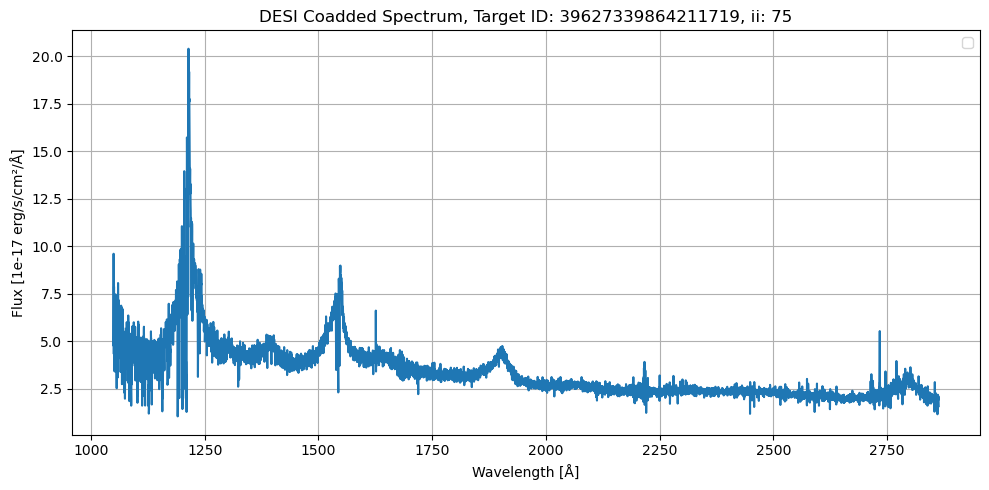

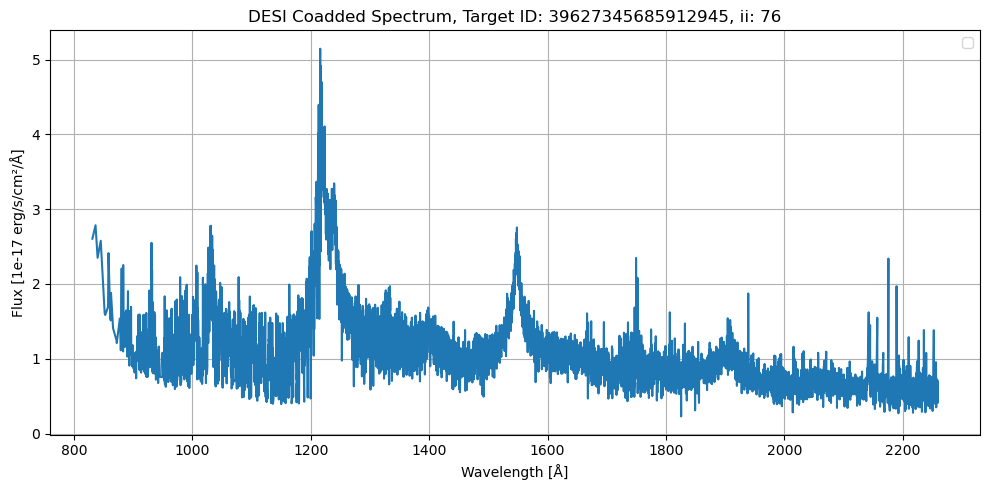

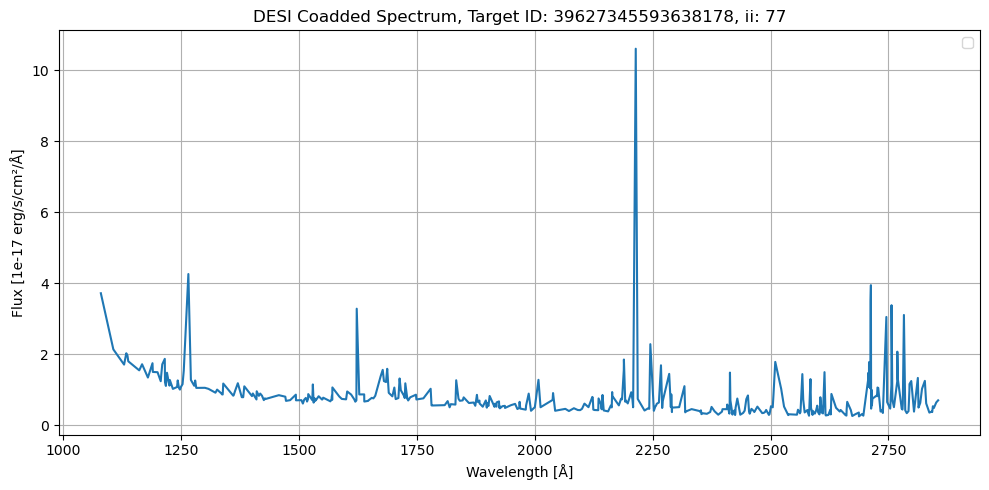

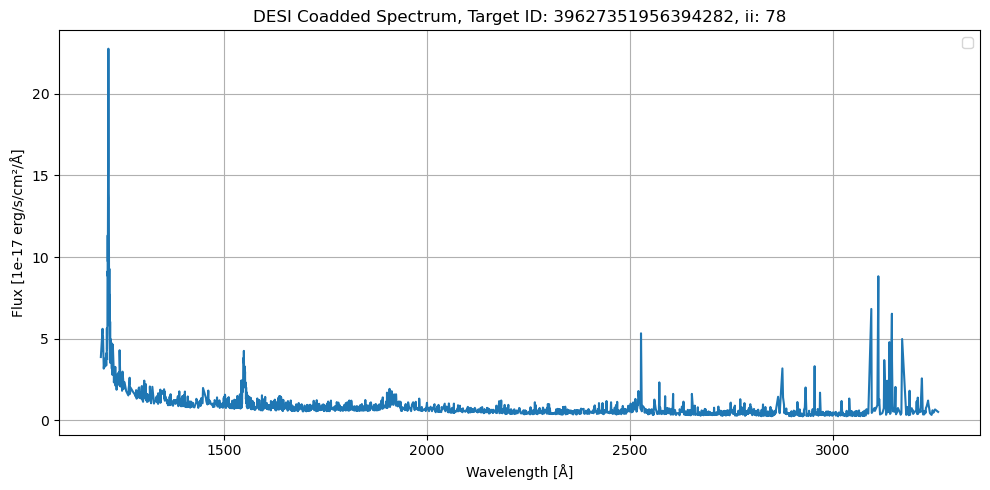

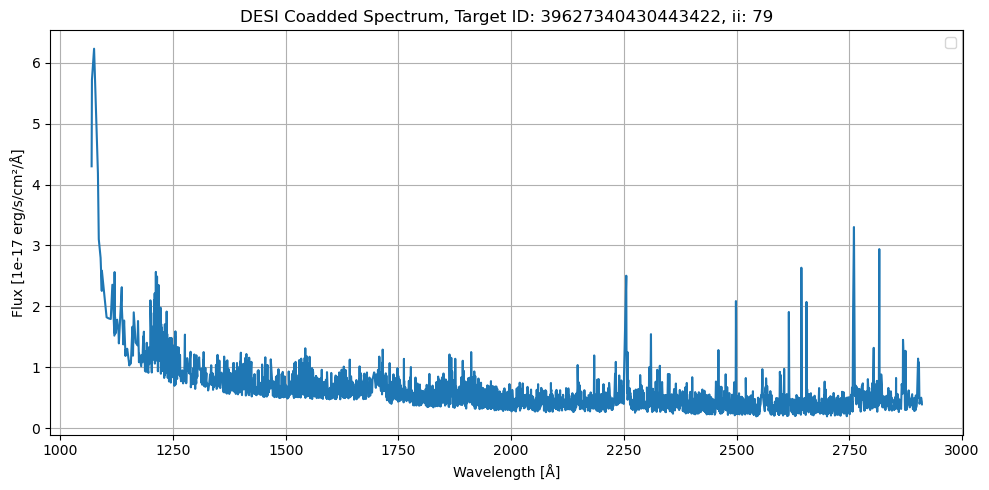

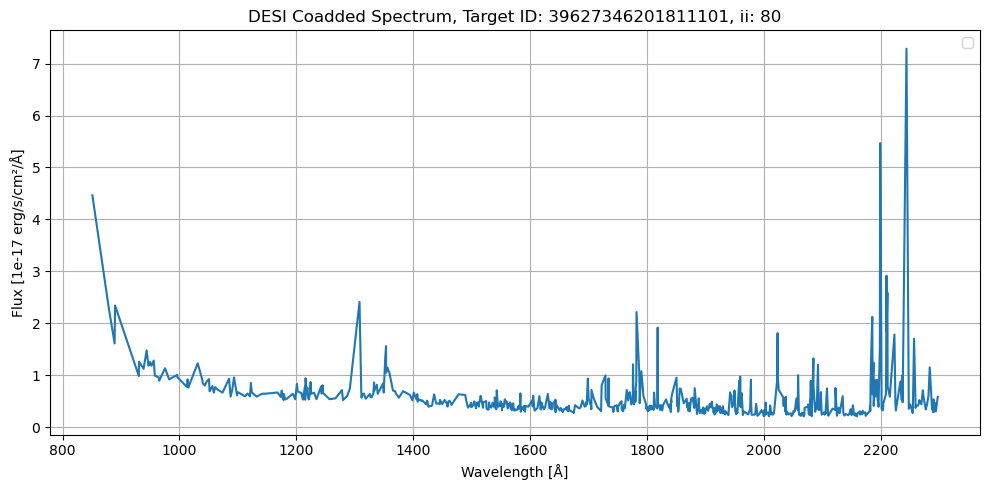

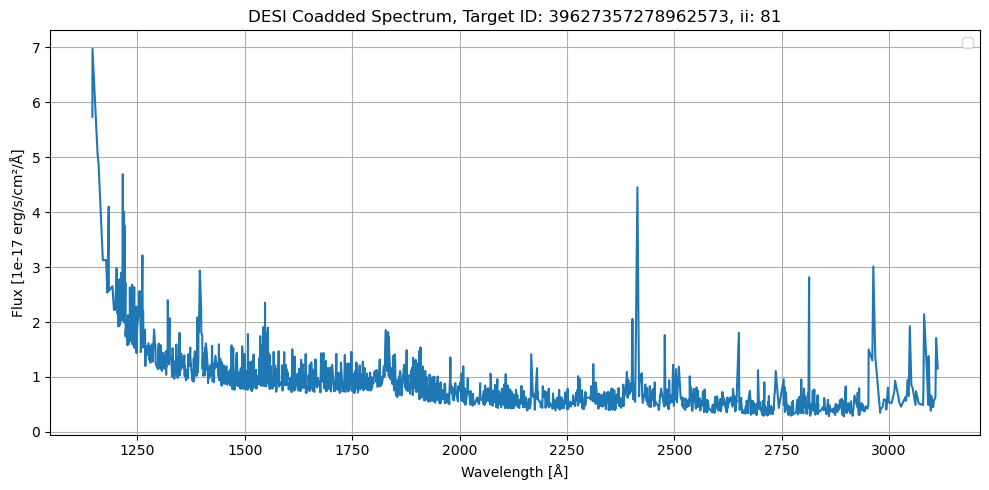

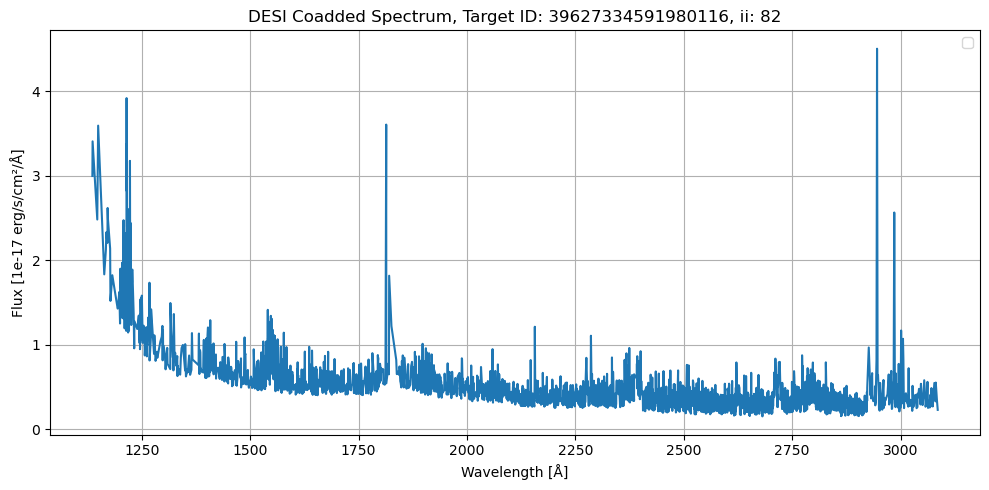

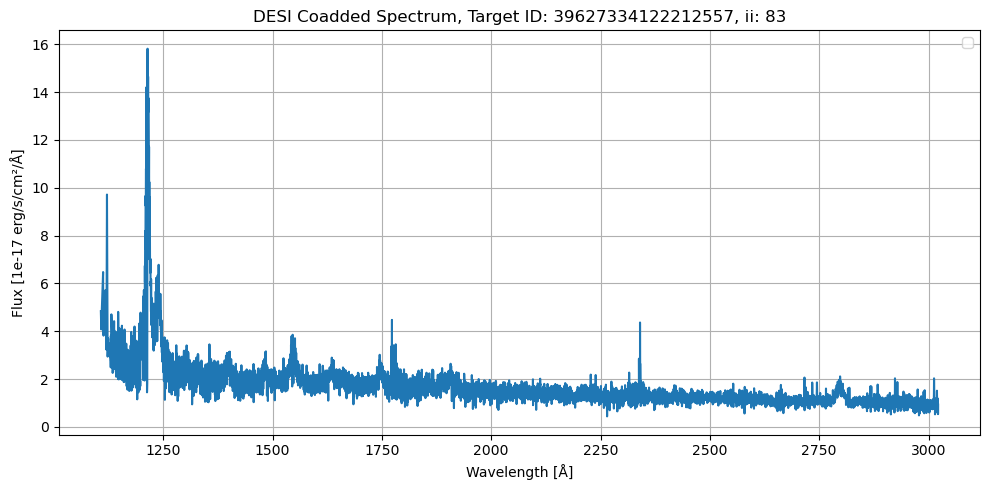

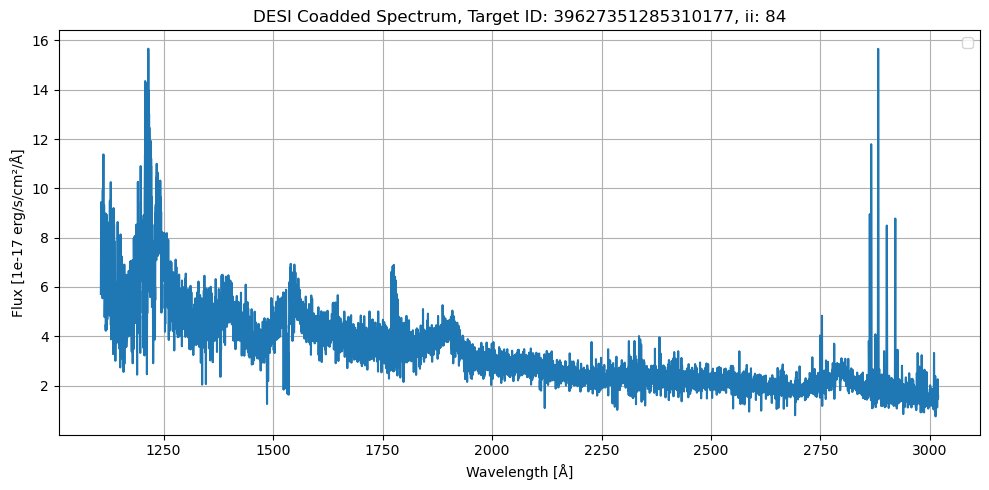

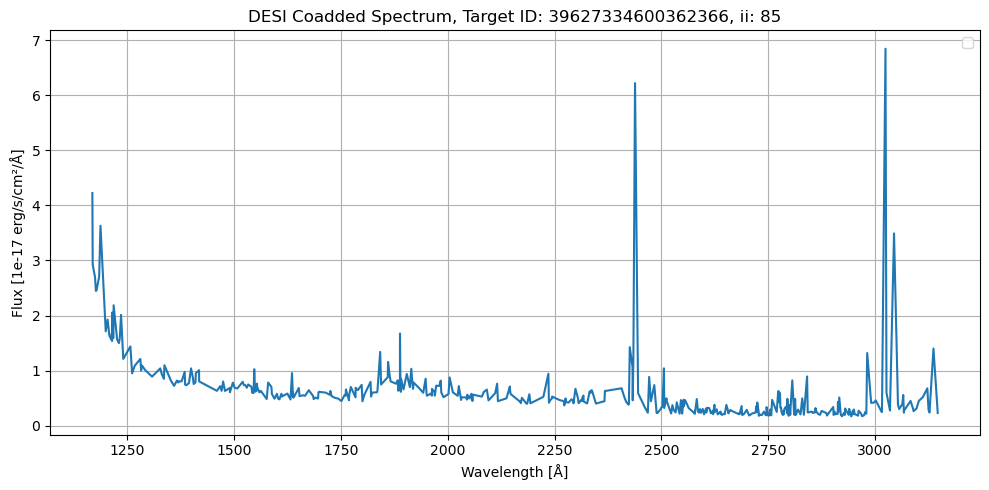

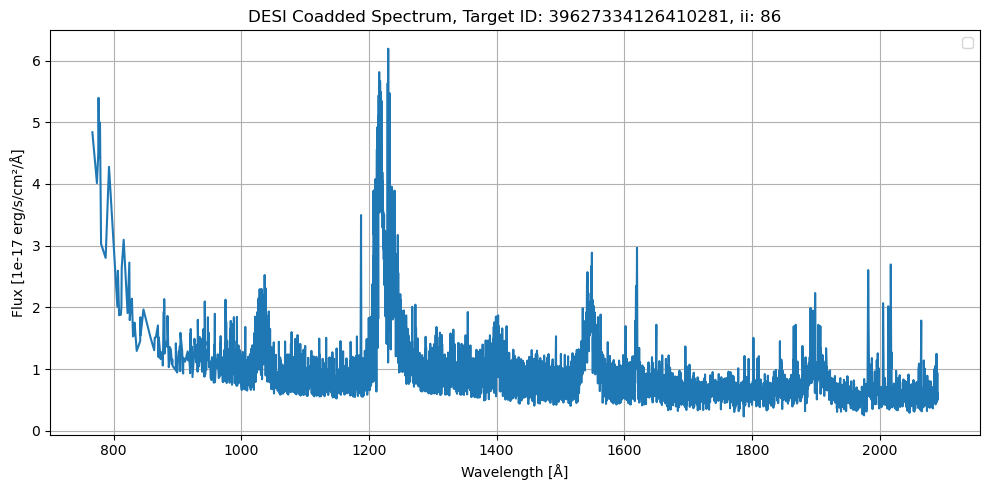

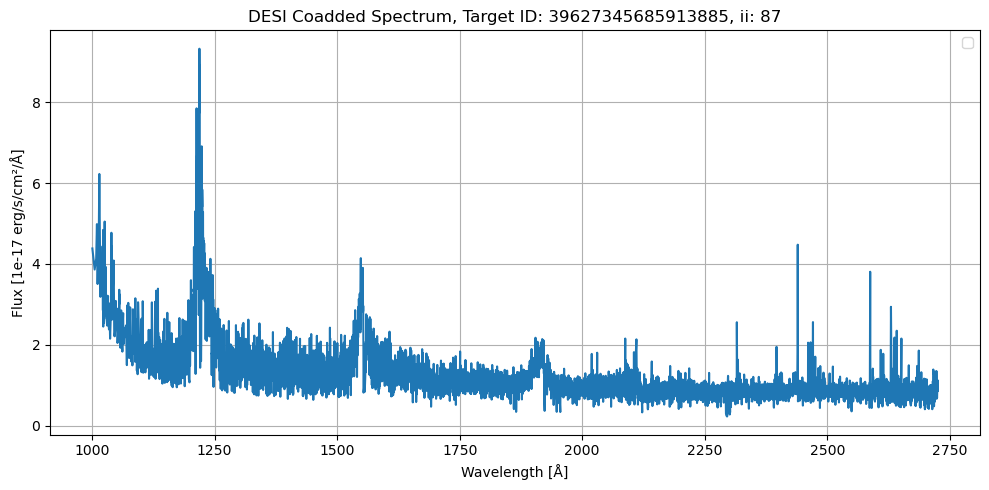

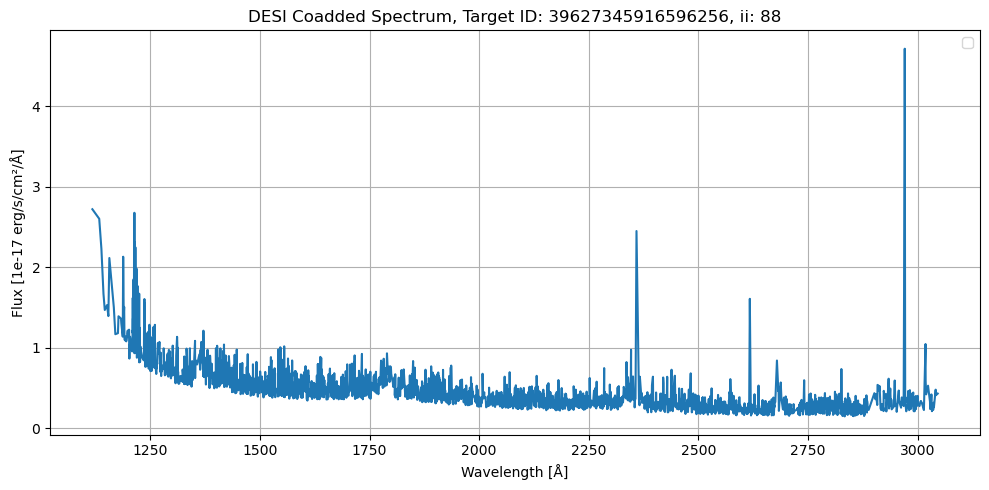

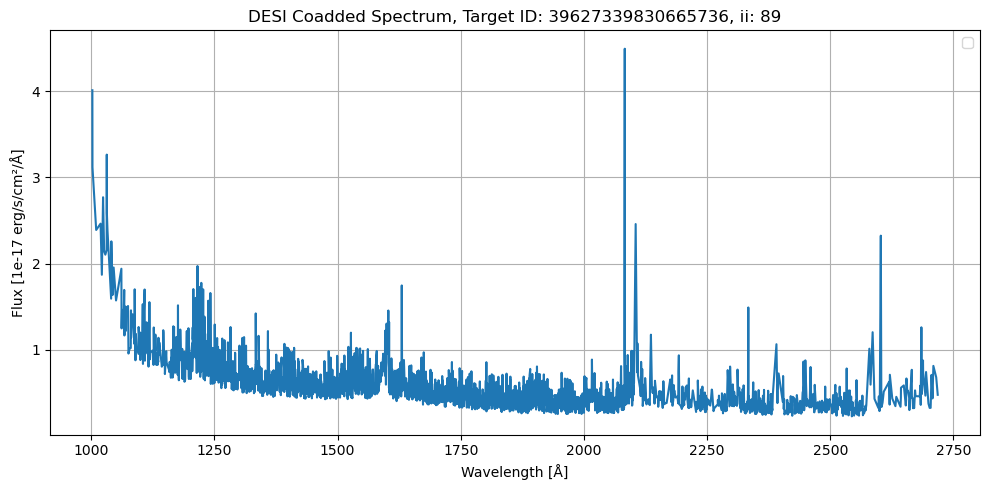

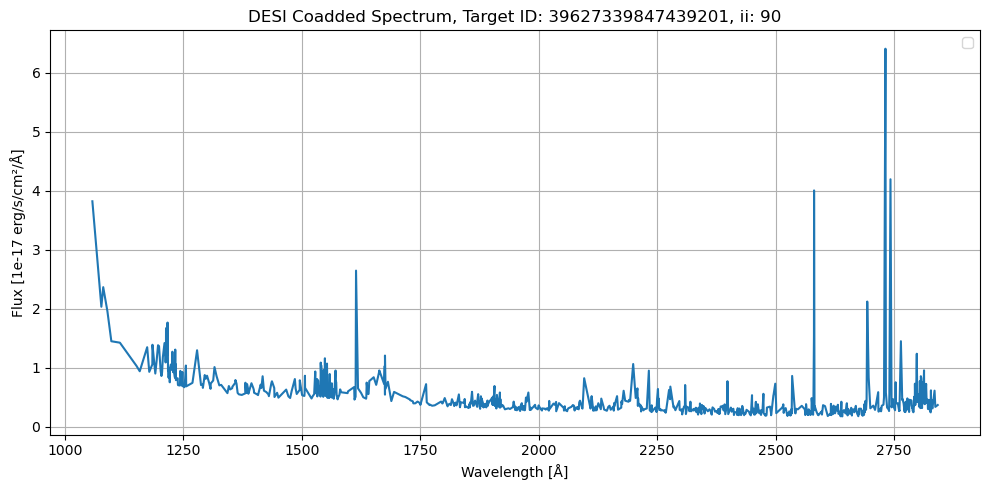

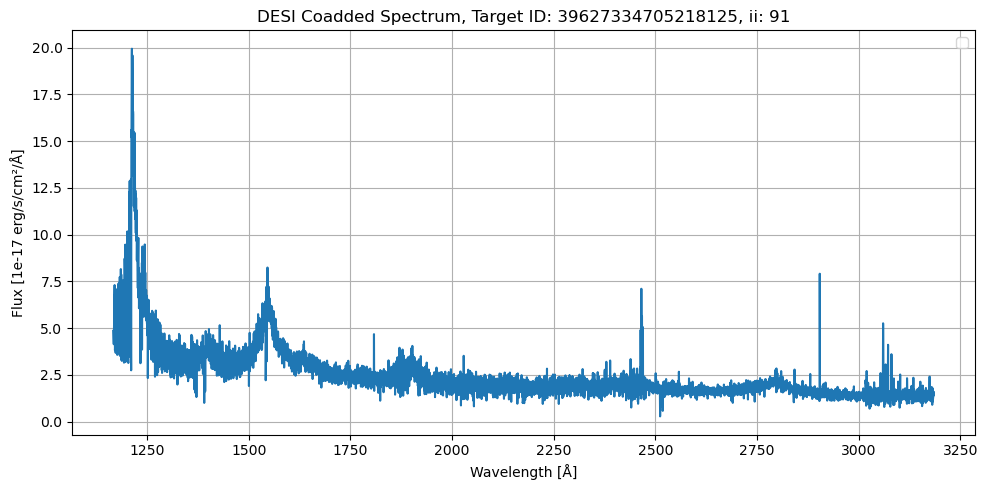

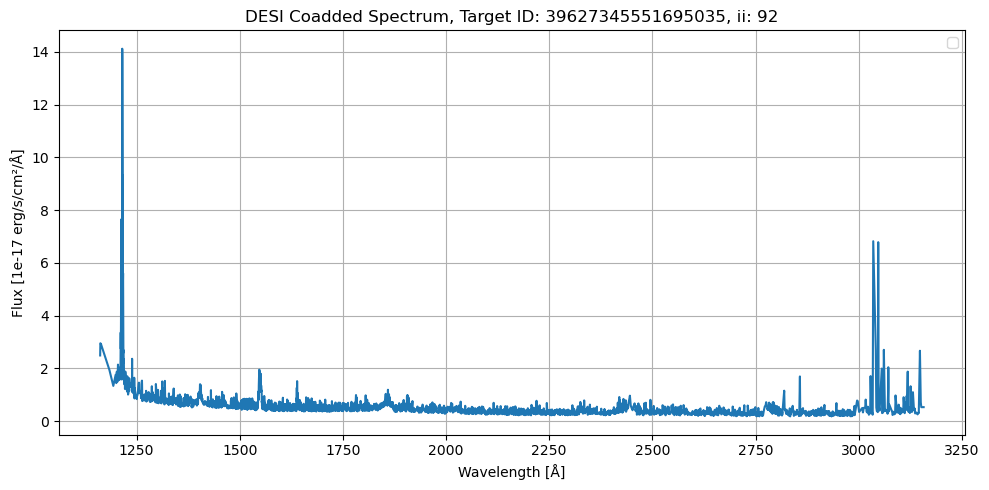

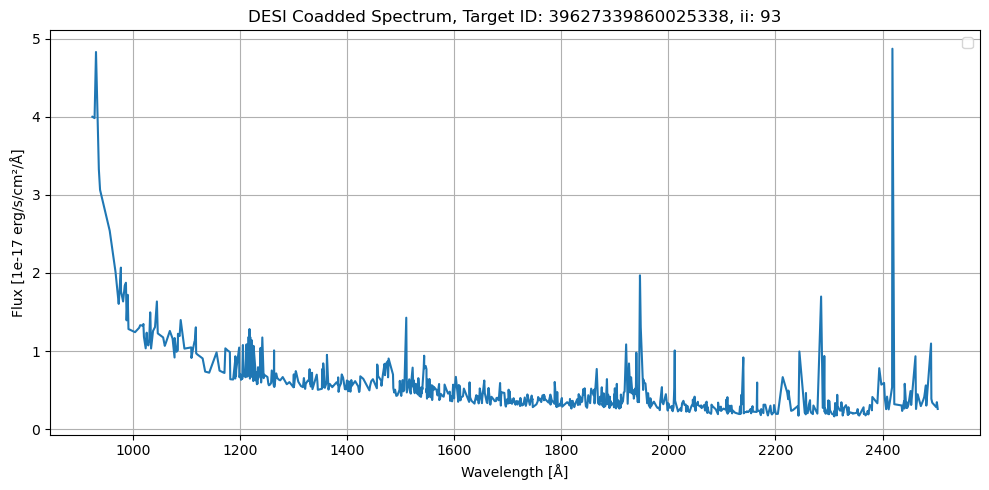

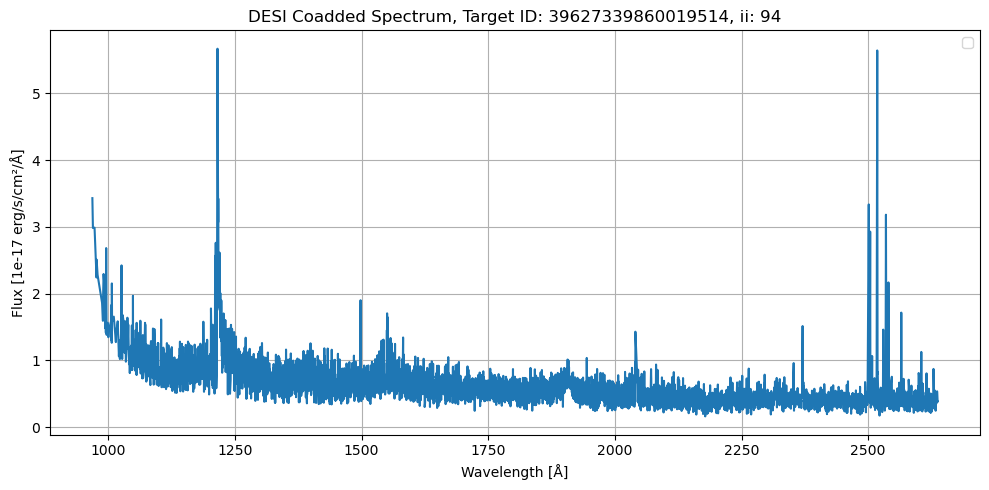

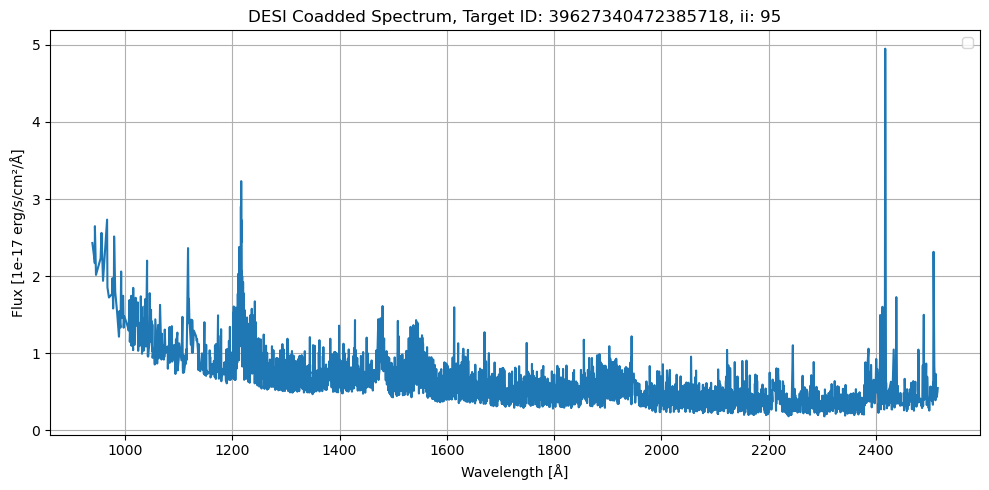

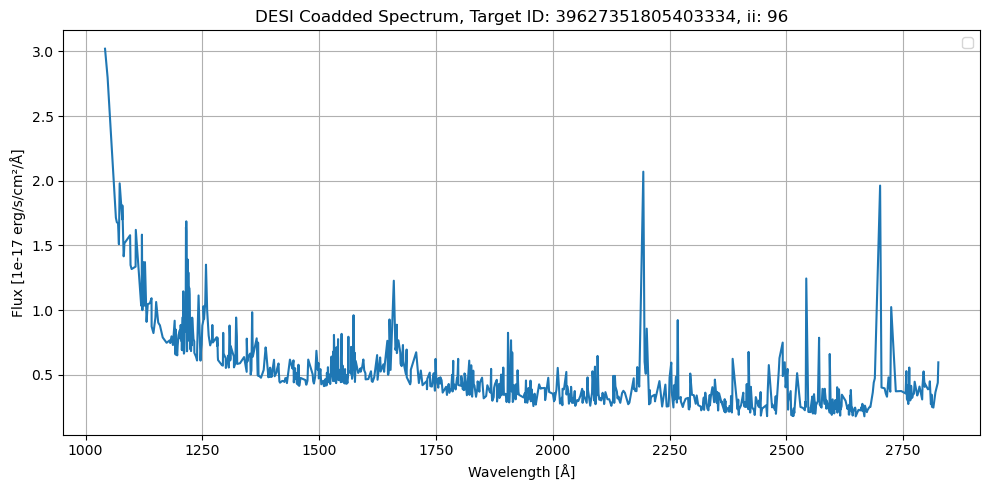

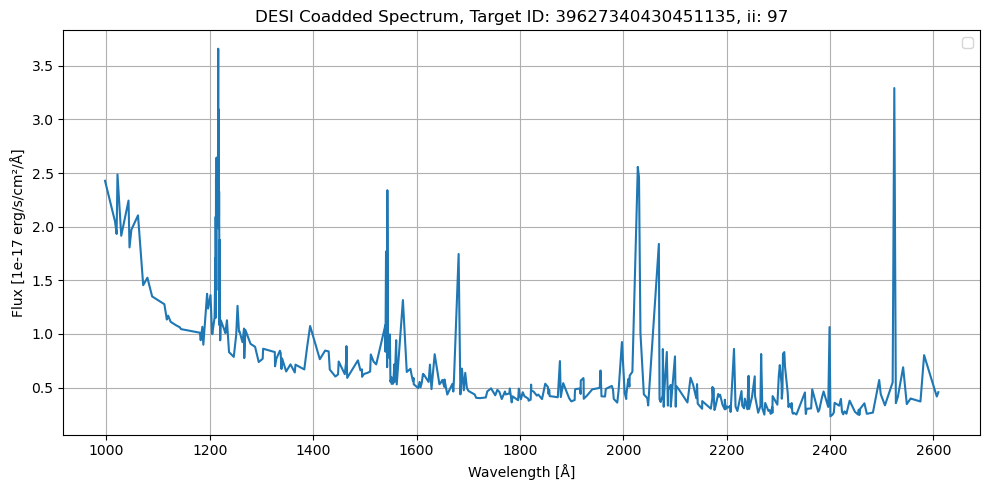

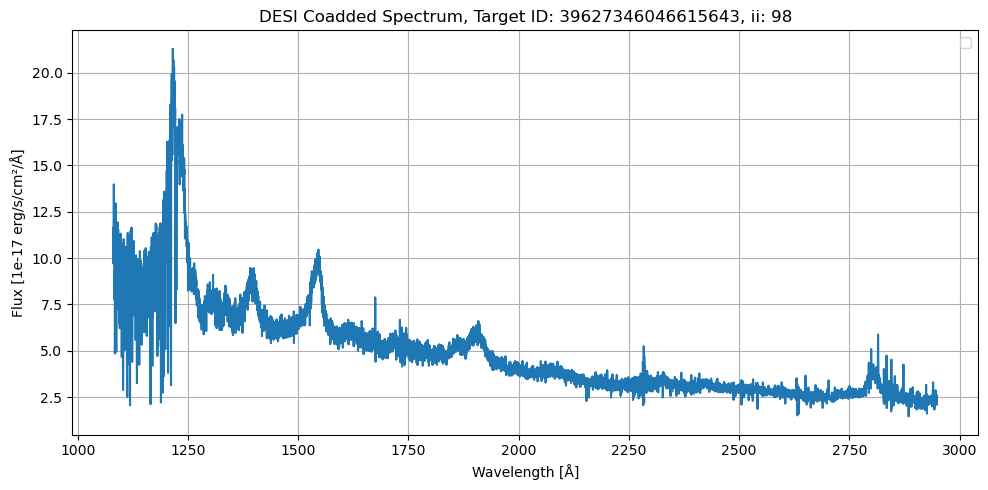

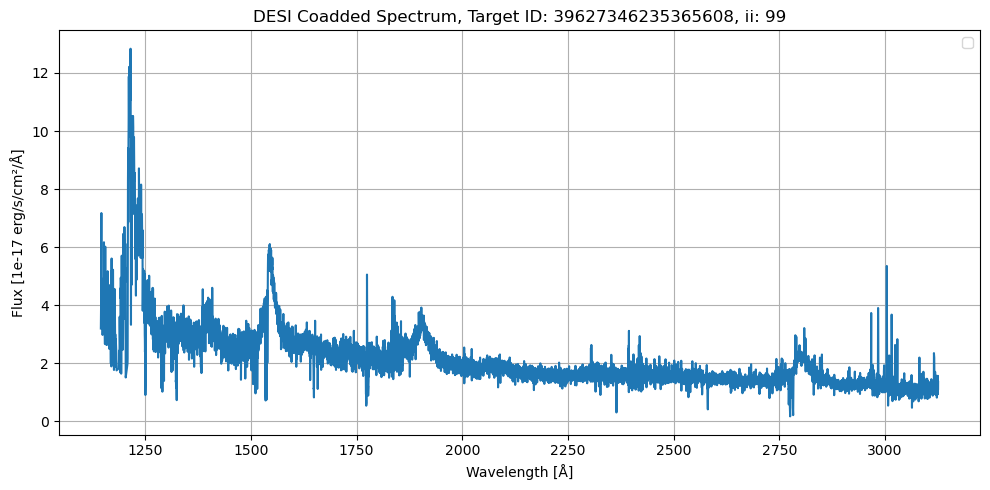

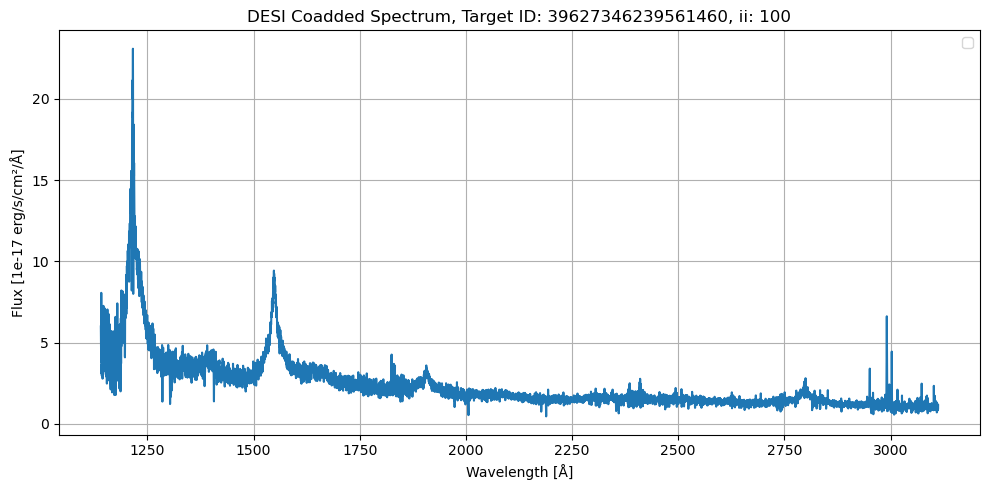

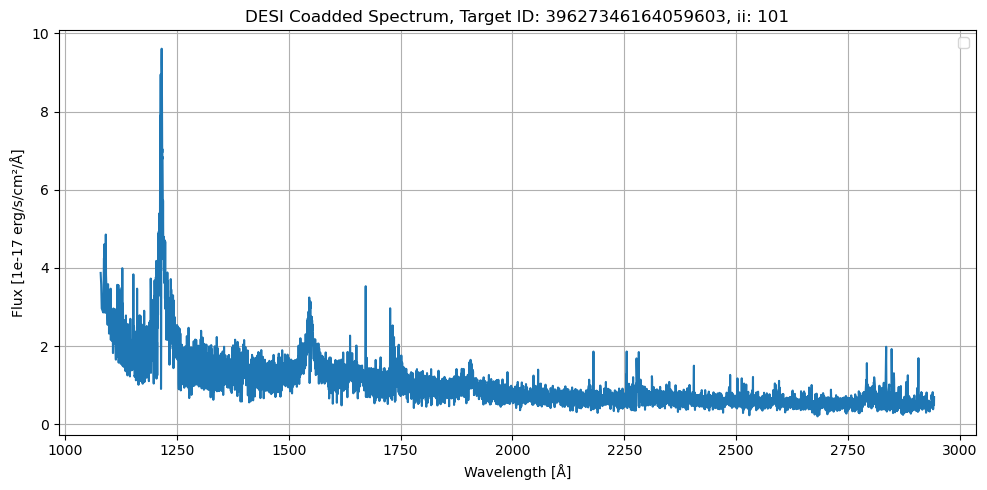

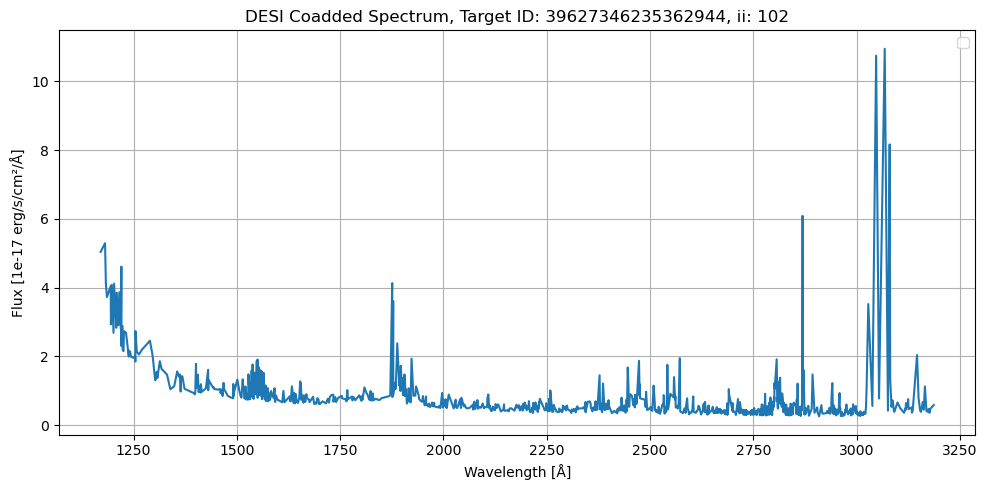

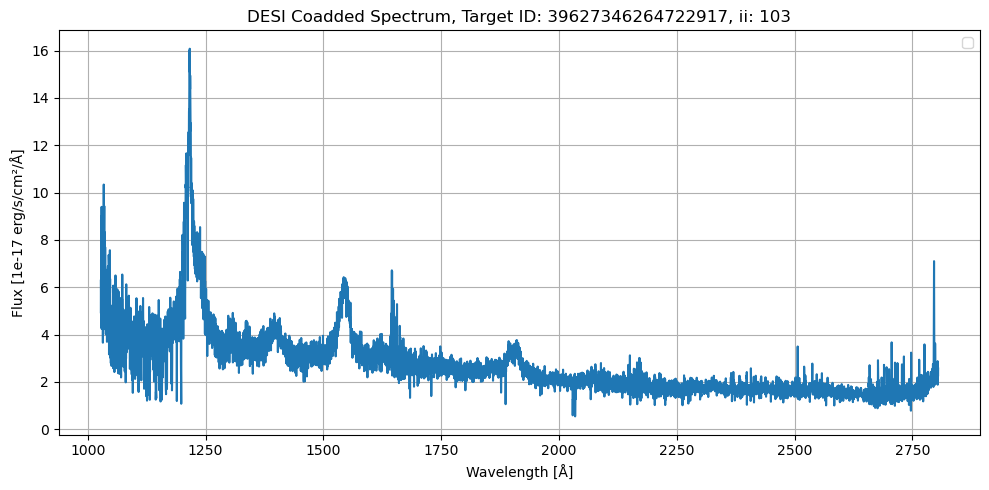

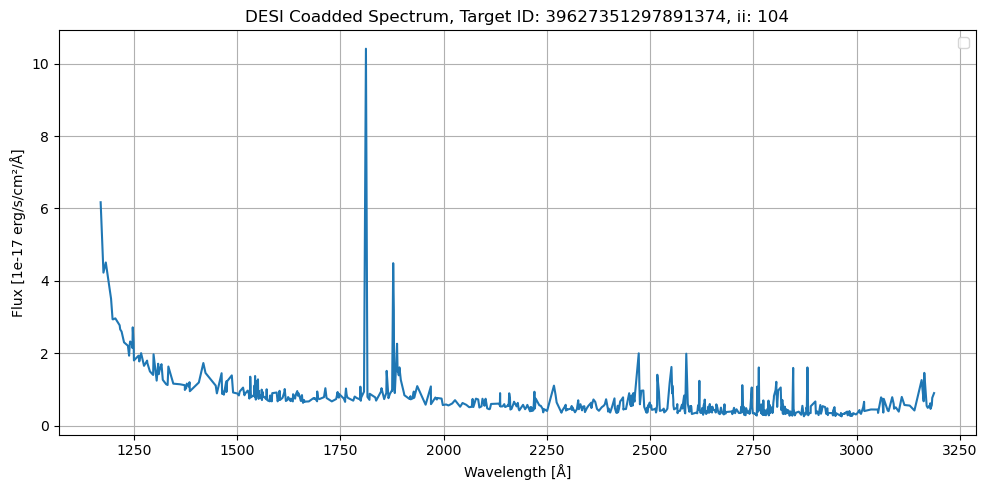

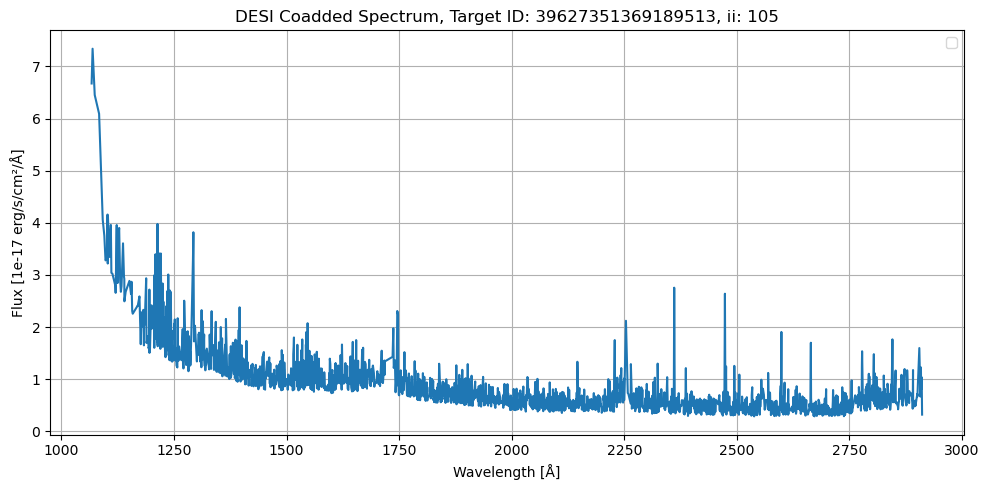

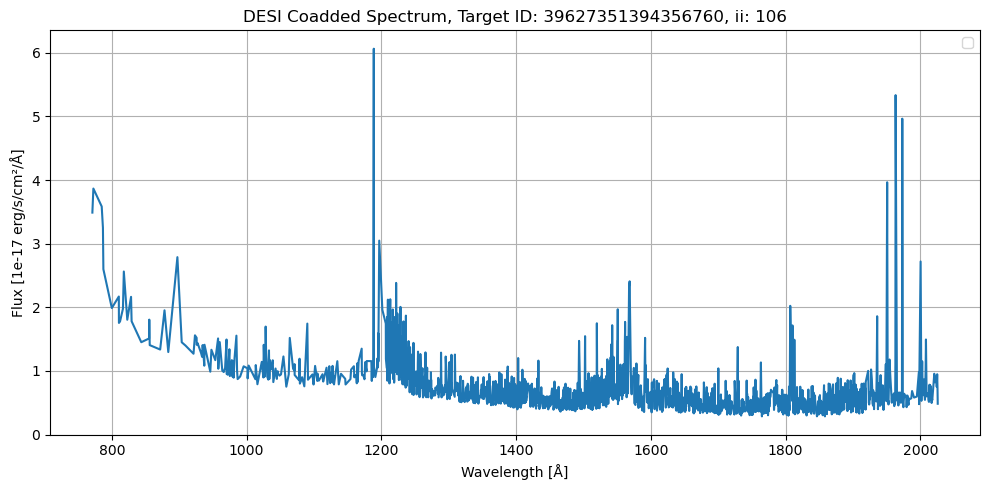

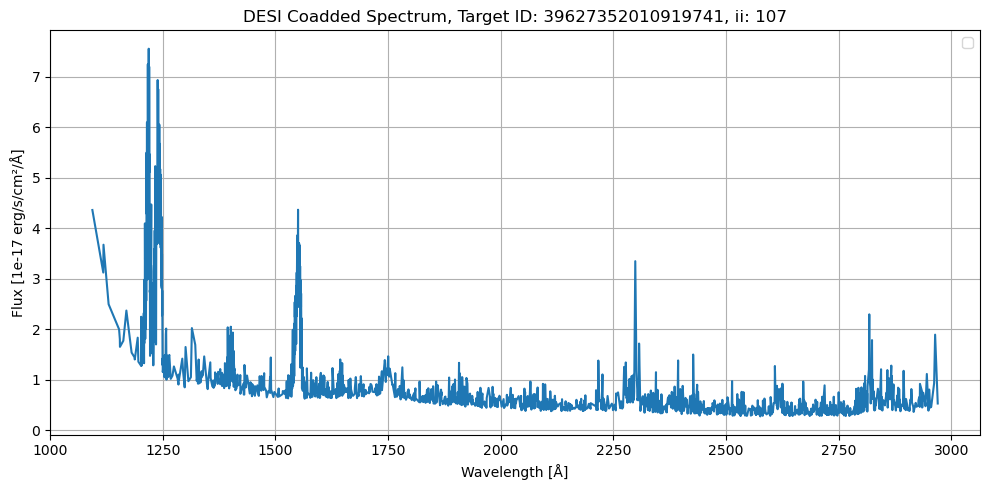

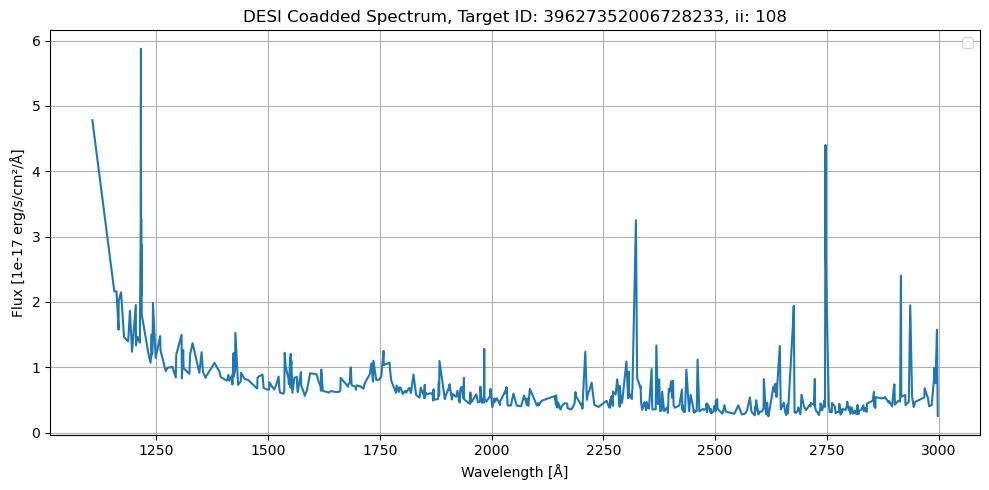

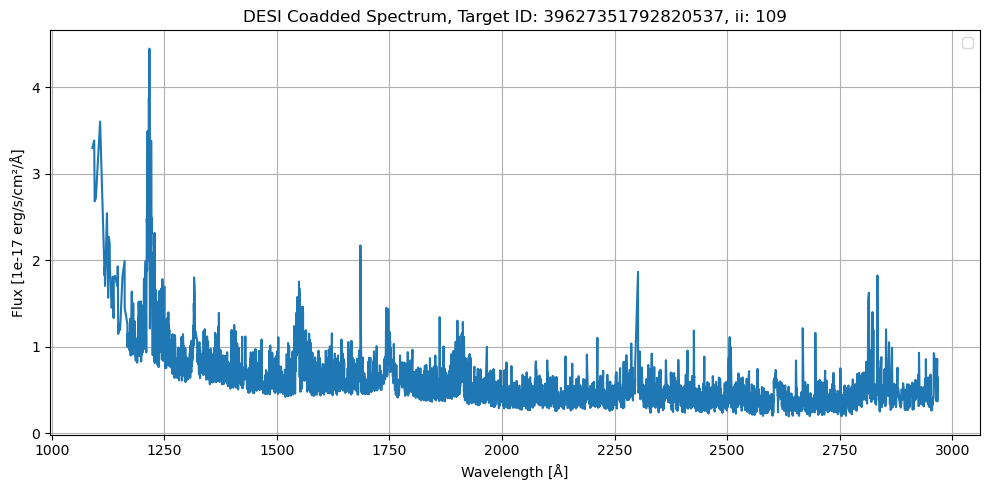

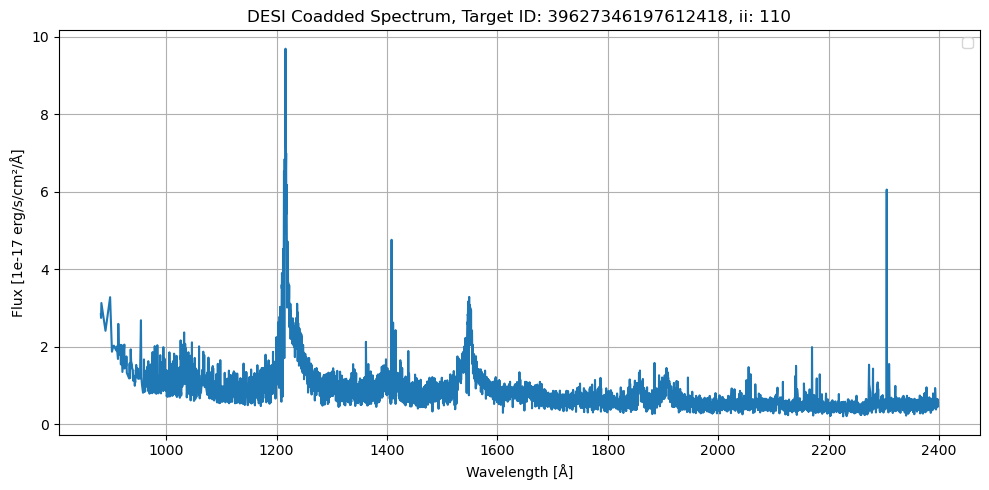

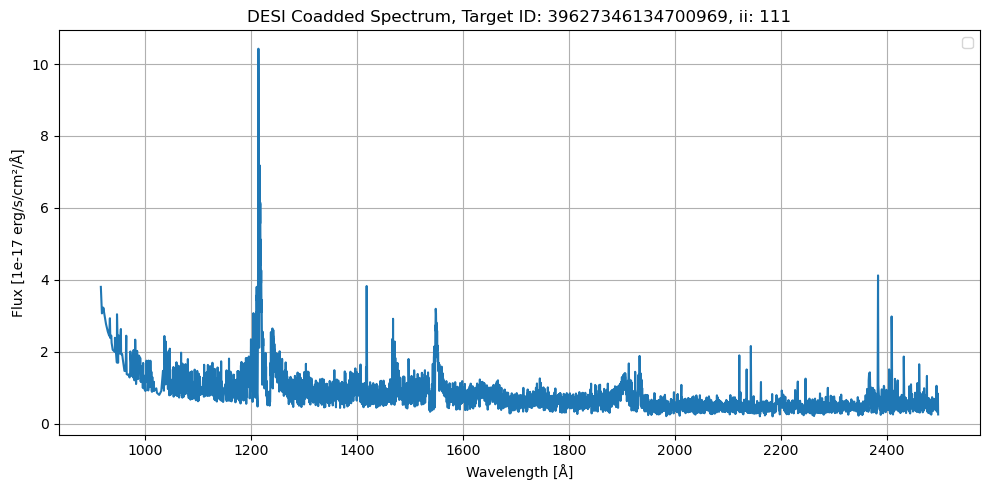

In [19]:
for ii in range(len(flux)):
    thisflux = flux[ii]
    thisivar = ivar[ii]
    thiswave = wave[ii]

    good = thisflux*np.sqrt(thisivar)>2
    thiswave = thiswave[good]
    thisflux = thisflux[good]

    plt.figure(figsize=(10, 5))
    plt.plot(thiswave, thisflux)
    plt.xlabel("Wavelength [Å]")
    plt.ylabel("Flux [1e-17 erg/s/cm²/Å]")
    plt.title("DESI Coadded Spectrum, Target ID: {}, ii: {}".format(data["TARGETID"][validQSOidx[ii]], ii))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()